# Data Source and goal of this case study

Data: https://www.kaggle.com/patrickb1912/ipl-complete-dataset-20082020  
          
Goal:   
    1. Identify cluster of players with similar performance  
    2. Given a player name, identify similar players  
    3. Create a best team with mix of batsman, bowler, allrounders & wicket-keeper
    

# Imports and data read

In [1]:
import pandas as pd
import matplotlib.pyplot  as plt

import seaborn as sns
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display


from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn.cluster import DBSCAN

In [2]:
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams["axes.grid"] = False

In [3]:
balldf = pd.read_csv("data/IPL_2008_2020/IPL Ball-by-Ball 2008-2020.csv")

In [4]:
matches = pd.read_csv("data/IPL_2008_2020/IPL Matches 2008-2020.csv")

In [5]:
balldf.head(3)

id  inning  over  ball      batsman  non_striker     bowler  \
0  335982       1     6     5   RT Ponting  BB McCullum  AA Noffke   
1  335982       1     6     6  BB McCullum   RT Ponting  AA Noffke   
2  335982       1     7     1  BB McCullum   RT Ponting     Z Khan   

   batsman_runs  extra_runs  total_runs  non_boundary  is_wicket  \
0             1           0           1             0          0   
1             1           0           1             0          0   
2             0           0           0             0          0   

  dismissal_kind player_dismissed fielder extras_type           batting_team  \
0            NaN              NaN     NaN         NaN  Kolkata Knight Riders   
1            NaN              NaN     NaN         NaN  Kolkata Knight Riders   
2            NaN              NaN     NaN         NaN  Kolkata Knight Riders   

                  bowling_team  
0  Royal Challengers Bangalore  
1  Royal Challengers Bangalore  
2  Royal Challengers Bangalore

In [6]:
matches.head(3)

id        city        date player_of_match  \
0  335982   Bangalore  2008-04-18     BB McCullum   
1  335983  Chandigarh  2008-04-19      MEK Hussey   
2  335984       Delhi  2008-04-19     MF Maharoof   

                                        venue  neutral_venue  \
0                       M Chinnaswamy Stadium              0   
1  Punjab Cricket Association Stadium, Mohali              0   
2                            Feroz Shah Kotla              0   

                         team1                  team2  \
0  Royal Challengers Bangalore  Kolkata Knight Riders   
1              Kings XI Punjab    Chennai Super Kings   
2             Delhi Daredevils       Rajasthan Royals   

                   toss_winner toss_decision                 winner   result  \
0  Royal Challengers Bangalore         field  Kolkata Knight Riders     runs   
1          Chennai Super Kings           bat    Chennai Super Kings     runs   
2             Rajasthan Royals           bat       Delhi Daredevils  wickets   

   result_margin eliminator method    umpire1         umpire2  
0          140.0          N    NaN  Asad Rauf     RE Koertzen  
1           33.0          N    NaN  MR Benson      SL Shastri  
2            9.0          N    NaN  Aleem Dar  GA Pratapkumar

In [7]:
balldf.shape

(193468, 18)

In [8]:
matches.shape

(816, 17)

# Check Missing

In [9]:
balldf.isnull().sum()

id                       0
inning                   0
over                     0
ball                     0
batsman                  0
non_striker              0
bowler                   0
batsman_runs             0
extra_runs               0
total_runs               0
non_boundary             0
is_wicket                0
dismissal_kind      183973
player_dismissed    183973
fielder             186684
extras_type         183235
batting_team             0
bowling_team           191
dtype: int64

The variables with missing data is not used to create the player statistics in this analysis and can be ignored.

# Create batsman statistics

## Variables by grouping on batsman

In [10]:
# Group details on batsmen
batgroup = balldf.groupby(['batsman'])

# Create a batting dataframe with a summary statistics for each batsman
batdf = pd.DataFrame(batgroup['ball'].count()).rename(columns={'ball':'balls_faced'})
batdf['innings'] = batgroup['id'].nunique()
batdf['runs'] = batgroup['batsman_runs'].sum()
batdf['4s'] = balldf[balldf['batsman_runs'] == 4].groupby('batsman')['batsman_runs'].count()
batdf['4s'].fillna(0,inplace=True)
batdf['6s'] = balldf[balldf['batsman_runs'] == 6].groupby('batsman')['batsman_runs'].count()
batdf['6s'].fillna(0,inplace=True)


## Derived variable - Batsman average & strike rate

In [11]:
# Batting average = total rus scored/no. of times batsman is been dismissed
# Approximated here to matches instead of no. of dismissals
batdf['bat_average'] = round(batdf['runs']/batdf['innings'],2)

In [12]:
# Strike Rate = (Runs Scored / Balls faced) * 100
batdf['bat_strike'] = round(batdf['runs']/batdf['balls_faced']*100,2)


In [13]:
display(batdf.tail())

balls_faced  innings  runs     4s     6s  bat_average  \
batsman                                                                
YV Takawale            183       10   192   26.0    3.0        19.20   
Yashpal Singh           67        4    47    5.0    0.0        11.75   
Younis Khan              7        1     3    0.0    0.0         3.00   
Yuvraj Singh          2205      126  2750  217.0  149.0        21.83   
Z Khan                 141       27   117   11.0    2.0         4.33   

               bat_strike  
batsman                    
YV Takawale        104.92  
Yashpal Singh       70.15  
Younis Khan         42.86  
Yuvraj Singh       124.72  
Z Khan              82.98

# Create bowler statistics

## Variables by grouping on bowler

In [14]:
balldf['dismissal_kind'].unique()

array([nan, 'caught', 'run out', 'bowled', 'lbw', 'retired hurt',
       'stumped', 'caught and bowled', 'hit wicket',
       'obstructing the field'], dtype=object)

In [15]:
# Group details on bowler
bowlgroup = balldf.groupby(['bowler'])

# Create a bowling dataframe (bowldf) with a summary statistics for each batsman
bowldf = pd.DataFrame(bowlgroup['ball'].count()).rename(columns={'ball':'balls_bowled'})

# Get no. of wickets taken by each bowler
bwl_wkts = balldf[balldf['dismissal_kind'].isin(['caught','bowled', 'lbw','stumped', 'caught and bowled', 'hit wicket'])]
bowldf['wickets'] = bwl_wkts.groupby(['bowler'])['ball'].count()
bowldf['wickets'].fillna(0,inplace=True)
 
# Calculate the total no. of overs bowled
overs = pd.DataFrame(balldf.groupby(['bowler','id'])['over'].nunique())
bowldf['overs'] = overs.groupby(['bowler'])['over'].sum()    

# Calculate the runs conceded
bowldf['runs_conceded'] = balldf.groupby('bowler')['batsman_runs'].sum()
bowldf['runs_conceded'] = bowldf['runs_conceded'].fillna(0)
# Add the runs conceded through wide and noball
bowldf['runs_conceded'] = bowldf['runs_conceded'].add(balldf[balldf['extras_type'].isin(['wides','noballs'])].groupby('bowler')['extra_runs'].sum(),fill_value=0)

bowldf.head()


balls_bowled  wickets  overs  runs_conceded
bowler                                                     
A Ashish Reddy           270     18.0     45          396.0
A Chandila               234     11.0     39          242.0
A Choudhary              108      5.0     17          144.0
A Dananjaya               25      0.0      4           47.0
A Flintoff                66      2.0     11          105.0

## Derived variable - Bowler econ rate

In [16]:
# Note - roughly apprx to overs.  Should be runs_conceded/overs.balls
bowldf['bowl_econ'] = round(bowldf['runs_conceded']/bowldf['overs'],2)

In [17]:
display(bowldf.tail())

balls_bowled  wickets  overs  runs_conceded  bowl_econ
bowler                                                              
YA Abdulla             222     15.0     35          307.0       8.77
YK Pathan             1184     42.0    193         1415.0       7.33
YS Chahal             2188    121.0    359         2723.0       7.58
Yuvraj Singh           882     36.0    146         1077.0       7.38
Z Khan                2276    102.0    371         2782.0       7.50

# Get all players list along with the matches count

Getting total no. of matches:  
- If the player's name occurs as batsman, non-striker or bowler consider the player has played that match  
- Note: this is a rough approximation for the matches played (there could be players who have played in the match but did not get a chance to bat or bowl in the match)


In [18]:
# Add each player to the final all players list
def update_player_with_match(player_name, id):
    if player_name in all_players_dict:
        all_players_dict[player_name].add(id)
    else:
        all_players_dict[player_name] = {id}

# Consider players listed as batsman, non striker or bowler
def update_player_list(x):
    update_player_with_match(x['batsman'],x['id'])
    update_player_with_match(x['non_striker'],x['id'])
    update_player_with_match(x['bowler'],x['id']) 
        


In [19]:
# Create a dataframe with all players list
all_players_dict = {}
out_temp = balldf.apply(lambda x: update_player_list(x),axis=1)
all_df = pd.DataFrame({'Players':list(all_players_dict.keys())})
all_df['matches'] = all_df['Players'].apply(lambda x: len(all_players_dict[x]))
all_df=all_df.set_index('Players')

# Merged player statistics

In [20]:
# Combine the batting and bowling dataframes to create a merged players dataframe
players = pd.merge(all_df,batdf, left_index=True, right_index=True,how='outer')
players = pd.merge(players,bowldf, left_index=True, right_index=True,how='outer')
players.fillna(0,inplace=True)

In [21]:
players.tail()

matches  balls_faced  innings    runs     4s     6s  \
YV Takawale         10        183.0     10.0   192.0   26.0    3.0   
Yashpal Singh        4         67.0      4.0    47.0    5.0    0.0   
Younis Khan          1          7.0      1.0     3.0    0.0    0.0   
Yuvraj Singh       129       2205.0    126.0  2750.0  217.0  149.0   
Z Khan              99        141.0     27.0   117.0   11.0    2.0   

               bat_average  bat_strike  balls_bowled  wickets  overs  \
YV Takawale          19.20      104.92           0.0      0.0    0.0   
Yashpal Singh        11.75       70.15           0.0      0.0    0.0   
Younis Khan           3.00       42.86           0.0      0.0    0.0   
Yuvraj Singh         21.83      124.72         882.0     36.0  146.0   
Z Khan                4.33       82.98        2276.0    102.0  371.0   

               runs_conceded  bowl_econ  
YV Takawale              0.0       0.00  
Yashpal Singh            0.0       0.00  
Younis Khan              0.0       0.00  
Yuvraj Singh          1077.0       7.38  
Z Khan                2782.0       7.50

# Create no. of catches statistics

In [22]:
balldf['dismissal_kind'].unique()

array([nan, 'caught', 'run out', 'bowled', 'lbw', 'retired hurt',
       'stumped', 'caught and bowled', 'hit wicket',
       'obstructing the field'], dtype=object)

In [23]:
# Total catches = Number of caught & bowled + number of catches as fielder
# Capture caught & bowled instances
catches_cb = balldf[(balldf['dismissal_kind'].isin(['caught and bowled']))].groupby('bowler')['ball'].count().rename('bowler_catches')
# Capture the catches
catches_c = balldf[(balldf['dismissal_kind'].isin(['caught']))].groupby('fielder')['ball'].count().rename('fielder_catches')
# Combine the caught & bowled and fielding catches to get the total catches.
catches_df = pd.merge(catches_cb,catches_c, left_index=True, right_index=True,how='outer')
catches_df.fillna(0,inplace=True)
catches_df['catches'] = catches_df['bowler_catches']+catches_df['fielder_catches']
catches_df.drop(['bowler_catches','fielder_catches'],axis=1,inplace=True)
# Merge total catches to players data
players = pd.merge(players,catches_df, left_index=True, right_index=True,how='outer')
players.fillna(0,inplace=True)

# Number of man of the  matches from matches file

In [24]:
# Number of man of the matches from matches file
players = pd.merge(players,matches['player_of_match'].value_counts(), left_index=True, right_index=True,how='left')
players['player_of_match']  = players[['player_of_match']].fillna(0)

In [25]:
players.head()

matches  balls_faced  innings   runs    4s    6s  bat_average  \
A Ashish Reddy     28.0        196.0     23.0  280.0  16.0  15.0        12.17   
A Chandila         12.0          7.0      2.0    4.0   0.0   0.0         2.00   
A Chopra            6.0         75.0      6.0   53.0   7.0   0.0         8.83   
A Choudhary         5.0         20.0      3.0   25.0   1.0   1.0         8.33   
A Dananjaya         1.0          5.0      1.0    4.0   0.0   0.0         4.00   

                bat_strike  balls_bowled  wickets  overs  runs_conceded  \
A Ashish Reddy      142.86         270.0     18.0   45.0          396.0   
A Chandila           57.14         234.0     11.0   39.0          242.0   
A Chopra             70.67           0.0      0.0    0.0            0.0   
A Choudhary         125.00         108.0      5.0   17.0          144.0   
A Dananjaya          80.00          25.0      0.0    4.0           47.0   

                bowl_econ  catches  player_of_match  
A Ashish Reddy       8.80      9.0              0.0  
A Chandila           6.21      7.0              1.0  
A Chopra             0.00      2.0              0.0  
A Choudhary          8.47      0.0              0.0  
A Dananjaya         11.75      0.0              0.0

# Filtering: Remove players who have played less matches

In [26]:
# Backup before data filtering
all_players = players.copy()

ALL_COLUMN_NAMES = list(players.columns)

In [27]:
players.shape

(648, 15)

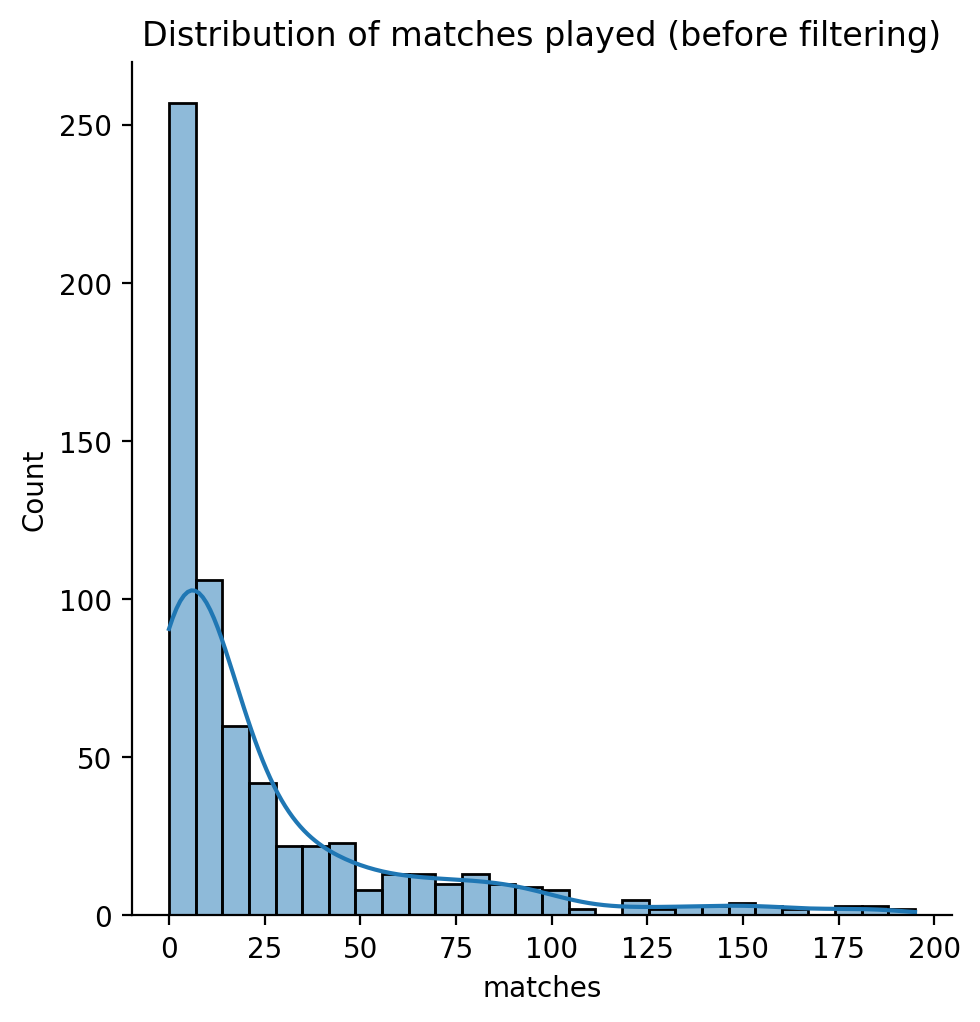

In [28]:
sns.displot(players['matches'],kde=True)
plt.title('Distribution of matches played (before filtering)')
plt.show()

In [29]:
players['matches'].describe()

count    648.000000
mean      26.532407
std       37.749302
min        0.000000
25%        3.000000
50%       10.000000
75%       34.000000
max      195.000000
Name: matches, dtype: float64

In [30]:
# Cut off on no. of matches

# Current Analysis: Players who have played atleast 10 matches
CUTOFF_MATCHES = 10
players=players[players['matches']>=CUTOFF_MATCHES]

In [31]:
players.shape

(336, 15)

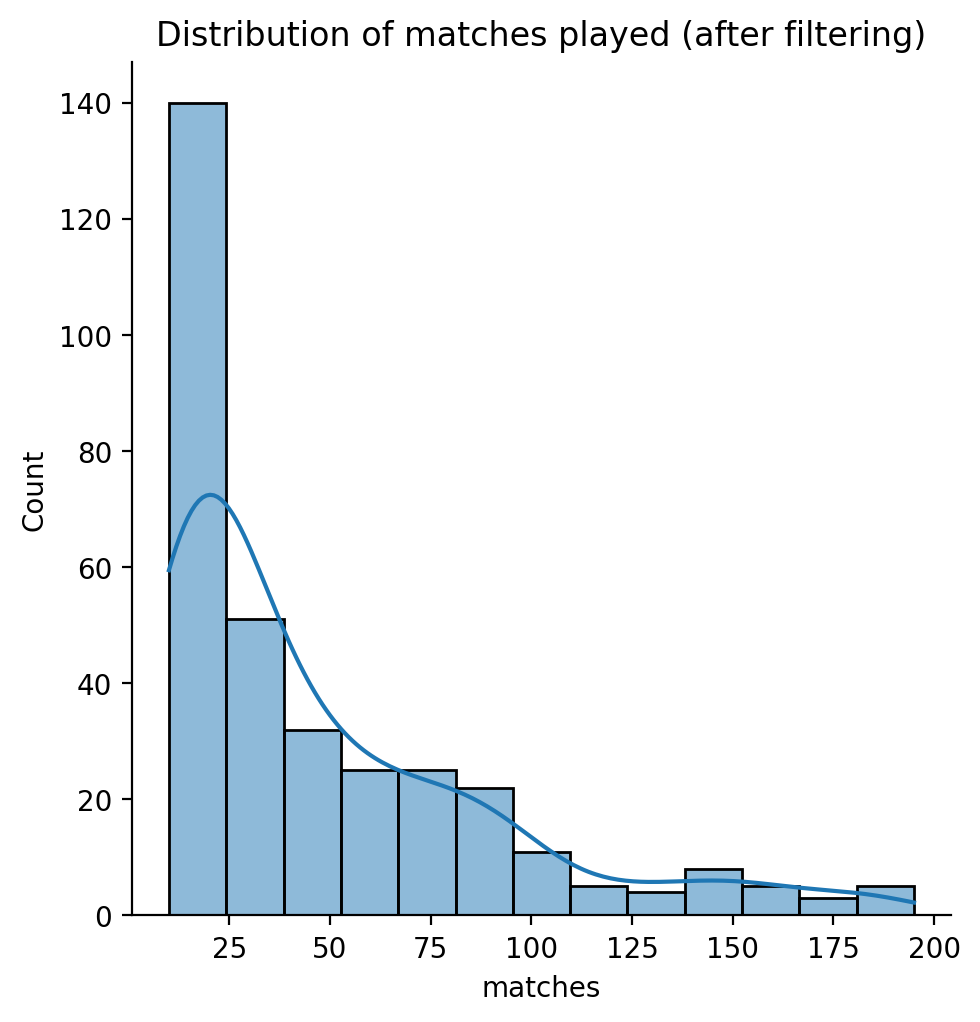

In [32]:
sns.displot(players['matches'],kde=True)
plt.title('Distribution of matches played (after filtering)')
plt.show()

In [33]:
players['matches'].describe()

count    336.000000
mean      48.184524
std       42.049671
min       10.000000
25%       17.000000
50%       32.000000
75%       68.250000
max      195.000000
Name: matches, dtype: float64

# Explore the players data

In [34]:
players.head()

matches  balls_faced  innings   runs    4s    6s  bat_average  \
A Ashish Reddy     28.0        196.0     23.0  280.0  16.0  15.0        12.17   
A Chandila         12.0          7.0      2.0    4.0   0.0   0.0         2.00   
A Kumble           42.0         49.0     15.0   35.0   3.0   0.0         2.33   
A Mishra          150.0        410.0     54.0  362.0  29.0   5.0         6.70   
A Mithun           16.0         26.0      6.0   34.0   4.0   1.0         5.67   

                bat_strike  balls_bowled  wickets  overs  runs_conceded  \
A Ashish Reddy      142.86         270.0     18.0   45.0          396.0   
A Chandila           57.14         234.0     11.0   39.0          242.0   
A Kumble             71.43         983.0     45.0  163.0         1058.0   
A Mishra             88.29        3233.0    160.0  529.0         3867.0   
A Mithun            130.77         312.0      7.0   48.0          472.0   

                bowl_econ  catches  player_of_match  
A Ashish Reddy       8.80      9.0              0.0  
A Chandila           6.21      7.0              1.0  
A Kumble             6.49     10.0              3.0  
A Mishra             7.31     21.0             11.0  
A Mithun             9.83      7.0              0.0

<function matplotlib.pyplot.show(*args, **kw)>

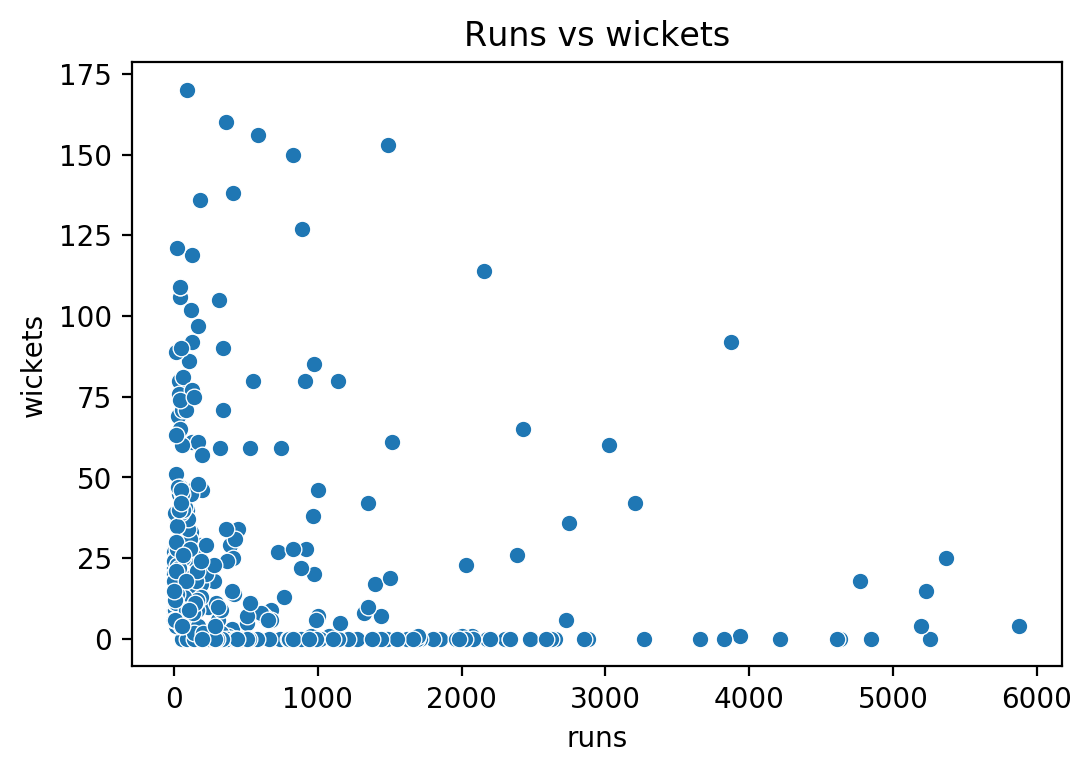

In [35]:
sns.scatterplot(data=players, x="runs", y="wickets")
plt.title("Runs vs wickets")
plt.show

In [36]:
players.columns

Index(['matches', 'balls_faced', 'innings', 'runs', '4s', '6s', 'bat_average',
       'bat_strike', 'balls_bowled', 'wickets', 'overs', 'runs_conceded',
       'bowl_econ', 'catches', 'player_of_match'],
      dtype='object')

# Scale the data

In [37]:
# Standard Scaler (mean = 0 and standard deviation = 1)
scaler = StandardScaler()

# fit_transform
players_scaled = pd.DataFrame(scaler.fit_transform(players),columns=players.columns)
players_scaled.shape
players_scaled.head()


# TESTING -  CONSIDER  ONLY RUNS AND WICKETS
#players_scaled  = players_scaled[['runs','wickets','catches']]

matches  balls_faced   innings      runs        4s        6s  bat_average  \
0 -0.480732    -0.421936 -0.284259 -0.375626 -0.450860 -0.242263    -0.121512   
1 -0.861802    -0.644246 -0.813057 -0.627066 -0.603947 -0.575235    -1.210416   
2 -0.147296    -0.594844 -0.485706 -0.598825 -0.575244 -0.575235    -1.175083   
3  2.424926    -0.170219  0.496348 -0.300922 -0.326477 -0.464245    -0.707186   
4 -0.766535    -0.621897 -0.712334 -0.599736 -0.565676 -0.553037    -0.817468   

   bat_strike  balls_bowled   wickets     overs  runs_conceded  bowl_econ  \
0    1.125984     -0.384855 -0.187779 -0.374215      -0.335988   0.676402   
1   -1.622592     -0.435834 -0.400011 -0.426504      -0.512530  -0.031829   
2   -1.164389      0.624825  0.630832  0.654125       0.422914   0.044736   
3   -0.623780      3.811051  4.117509  3.843723       3.643088   0.268964   
4    0.738323     -0.325379 -0.521287 -0.348071      -0.248863   0.958054   

    catches  player_of_match  
0 -0.391400        -0.653874  
1 -0.494182        -0.376823  
2 -0.340008         0.177280  
3  0.225296         2.393691  
4 -0.494182        -0.653874

In [38]:
# Mean around ~0 and standard deviation ~1 in all the scaled columns
players_scaled.describe()

matches   balls_faced       innings          runs            4s  \
count  336.000000  3.360000e+02  3.360000e+02  3.360000e+02  3.360000e+02   
mean     0.000000  3.436405e-17  1.057355e-17  2.114711e-17  1.057355e-17   
std      1.001491  1.001491e+00  1.001491e+00  1.001491e+00  1.001491e+00   
min     -0.909436 -6.524798e-01 -8.634189e-01 -6.307101e-01 -6.039473e-01   
25%     -0.742718 -5.863160e-01 -6.367911e-01 -5.874368e-01 -5.656756e-01   
50%     -0.385465 -4.442844e-01 -3.849824e-01 -4.526065e-01 -4.508604e-01   
75%      0.477897  1.708916e-01  2.697200e-01  1.723500e-01  1.375675e-01   
max      3.496685  4.768832e+00  4.021669e+00  4.724238e+00  5.050701e+00   

                 6s   bat_average    bat_strike  balls_bowled       wickets  \
count  3.360000e+02  3.360000e+02  3.360000e+02  3.360000e+02  3.360000e+02   
mean   3.172066e-17 -1.242392e-16 -3.013462e-16 -6.344132e-17  4.229421e-17   
std    1.001491e+00  1.001491e+00  1.001491e+00  1.001491e+00  1.001491e+00   
min   -5.752351e-01 -1.424556e+00 -3.454762e+00 -7.672020e-01 -7.335195e-01   
25%   -5.530370e-01 -8.787661e-01 -4.568840e-01 -7.544571e-01 -7.335195e-01   
50%   -3.976502e-01 -8.296667e-02  2.264122e-01 -3.763582e-01 -3.696924e-01   
75%    9.625791e-02  7.644941e-01  6.514282e-01  2.771722e-01  1.836280e-01   
max    7.171908e+00  2.603425e+00  2.191490e+00  4.119761e+00  4.420698e+00   

              overs  runs_conceded     bowl_econ       catches  \
count  3.360000e+02   3.360000e+02  3.360000e+02  3.360000e+02   
mean  -1.321694e-17  -1.321694e-17 -1.268826e-16  7.137148e-17   
std    1.001491e+00   1.001491e+00  1.001491e+00  1.001491e+00   
min   -7.663792e-01  -7.899529e-01 -1.729944e+00 -8.539212e-01   
25%   -7.511283e-01  -7.718975e-01 -4.484229e-03 -6.483560e-01   
50%   -3.698581e-01  -3.720984e-01  3.715074e-01 -3.400084e-01   
75%    2.881054e-01   2.930871e-01  5.909497e-01  1.867522e-01   
max    4.140024e+00   4.097054e+00  3.739025e+00  5.210250e+00   

       player_of_match  
count     3.360000e+02  
mean      3.700743e-17  
std       1.001491e+00  
min      -6.538741e-01  
25%      -6.538741e-01  
50%      -3.768228e-01  
75%       1.772799e-01  
max       5.718307e+00

# update player name as column

In [39]:
players.insert(0, 'name', players.index)

In [40]:
players.head()

name  matches  balls_faced  innings   runs    4s  \
A Ashish Reddy  A Ashish Reddy     28.0        196.0     23.0  280.0  16.0   
A Chandila          A Chandila     12.0          7.0      2.0    4.0   0.0   
A Kumble              A Kumble     42.0         49.0     15.0   35.0   3.0   
A Mishra              A Mishra    150.0        410.0     54.0  362.0  29.0   
A Mithun              A Mithun     16.0         26.0      6.0   34.0   4.0   

                  6s  bat_average  bat_strike  balls_bowled  wickets  overs  \
A Ashish Reddy  15.0        12.17      142.86         270.0     18.0   45.0   
A Chandila       0.0         2.00       57.14         234.0     11.0   39.0   
A Kumble         0.0         2.33       71.43         983.0     45.0  163.0   
A Mishra         5.0         6.70       88.29        3233.0    160.0  529.0   
A Mithun         1.0         5.67      130.77         312.0      7.0   48.0   

                runs_conceded  bowl_econ  catches  player_of_match  
A Ashish Reddy          396.0       8.80      9.0              0.0  
A Chandila              242.0       6.21      7.0              1.0  
A Kumble               1058.0       6.49     10.0              3.0  
A Mishra               3867.0       7.31     21.0             11.0  
A Mithun                472.0       9.83      7.0              0.0

# Finding optimal no. of clusters (k)

## Elbow method

Steps in elbow method:
- Initialize k with a range of values for the no. of clusters.   
- For each value of k, 
    - perform the k-means clustering  
    - compute the sum of squared distances of samples to the nearest cluster centre
- Plot a graph of k versus the sum of squared distances


In [41]:
def elbow_plot(min_k, max_k, k_max_iter):
    # Elbow-curve/sum of squared distances
    sum_squared_distances = []
    k_range = range(min_k, max_k+1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, max_iter=k_max_iter)
        kmeans.fit(players_scaled)

        sum_squared_distances.append(kmeans.inertia_)

    # Plot the score for each value of k
    plt.plot(k_range, sum_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

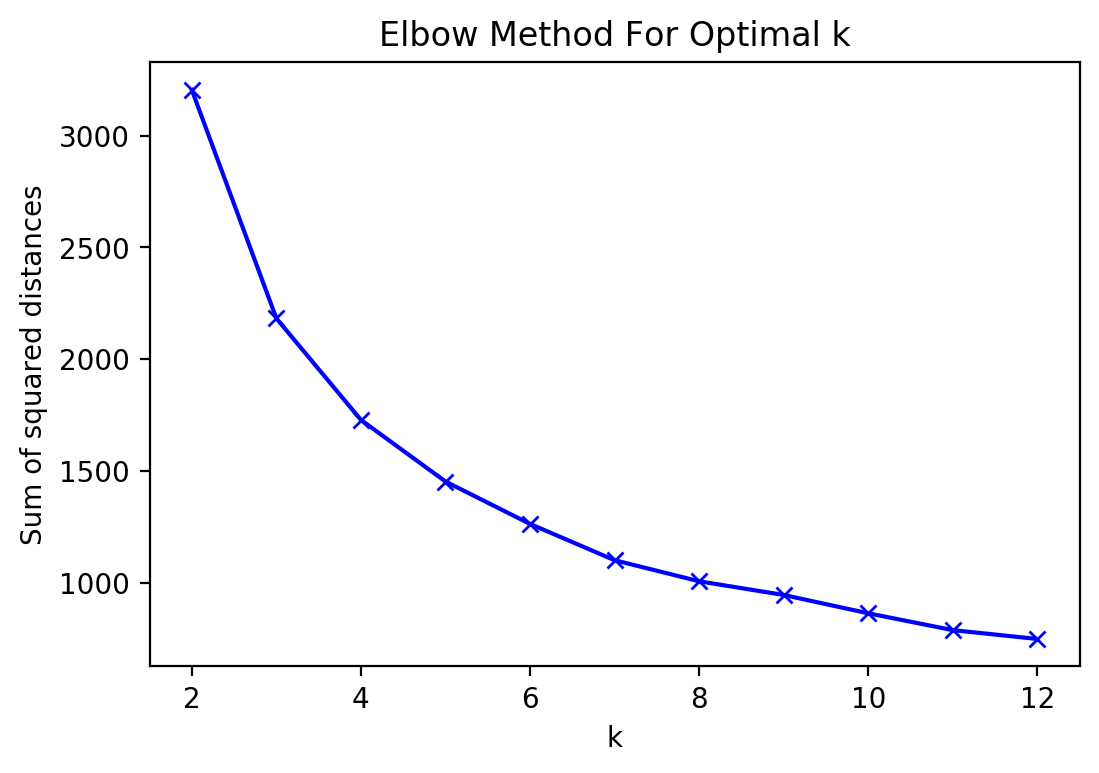

In [42]:
elbow_plot(2,12, 50)


Inference:
- As the no. of clusters (k) increases, the sum of squared distance tends to zero.   
- The plot of no. of clusters vs sum of squared distances will look like an arm. The elbow on the arm is optimal k.
- In the plot for the players dataset, the elbow is at k=5 indicating the optimal k for this dataset is 5

## Silhouette Analysis¶
silhouette score=(𝑝−𝑞)/𝑚𝑎𝑥(𝑝,𝑞)
 
𝑝  is the mean distance to the points in the nearest cluster that the data point is not a part of

𝑞  is the mean intra-cluster distance to all the points in its own cluster.

The value of the silhouette score range lies between -1 to 1.

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [43]:
# Method to compute the silhouette score for the given input
def compute_silhouette_score(input_df, min_k, max_k, k_max_iter):
    # silhouette analysis
    k_range = range(min_k, max_k+1)

    for k in k_range :
        # intialise kmeans
        kmeans = KMeans(n_clusters=k, max_iter=k_max_iter)
        kmeans.fit(input_df)
        cluster_labels = kmeans.labels_

        # silhouette score
        silhouette_avg = silhouette_score(input_df, cluster_labels)
        print(f"For k={k}, silhouette score = {silhouette_avg}")
        

In [44]:
compute_silhouette_score(players_scaled, 2,12,300)

For k=2, silhouette score = 0.48803222136569746
For k=3, silhouette score = 0.4433088208407482
For k=4, silhouette score = 0.3975620480608323
For k=5, silhouette score = 0.2802189699769682
For k=6, silhouette score = 0.307685987985714
For k=7, silhouette score = 0.3152133012643455
For k=8, silhouette score = 0.32026701831359766
For k=9, silhouette score = 0.31518600645215256
For k=10, silhouette score = 0.3172962795643867
For k=11, silhouette score = 0.316656619424125
For k=12, silhouette score = 0.31002634180310085


Inference:
- The optimal no. of clusters could be 4 

In [45]:
NUM_CLUSTERS = 5

# Utility Methods

In [46]:
players.head(2)

name  matches  balls_faced  innings   runs    4s  \
A Ashish Reddy  A Ashish Reddy     28.0        196.0     23.0  280.0  16.0   
A Chandila          A Chandila     12.0          7.0      2.0    4.0   0.0   

                  6s  bat_average  bat_strike  balls_bowled  wickets  overs  \
A Ashish Reddy  15.0        12.17      142.86         270.0     18.0   45.0   
A Chandila       0.0         2.00       57.14         234.0     11.0   39.0   

                runs_conceded  bowl_econ  catches  player_of_match  
A Ashish Reddy          396.0       8.80      9.0              0.0  
A Chandila              242.0       6.21      7.0              1.0

In [47]:
# Initialize few colour codes for each cluster
CLUSTER_COLORS = ['#F28A30','#0ABDA0','#008AC5','#D6618F','#F3CD05','#A882C1','#BDA589','#888C46',
                  '#36688D','#00743F','#0444BF','#A7414A','#1D65A6','red','green','blue','orange','pink','yellow']

In [48]:
# Show the top few players in each cluster (Players sorted on no. of matches played)
def  groupby_cluster(cluster_col, head_size):
    g = players.groupby([cluster_col]).apply(lambda x: x.sort_values(["matches"], ascending = False)).reset_index(drop=True)
    # select top N rows within each cluster
    display(g.groupby(cluster_col)['name',cluster_col].head(head_size))

In [49]:

def print_with_column_color_style(input_df):

    col_bgcolor_dict = dict(zip(input_df.columns,['background-color:'+i for i in CLUSTER_COLORS]))
    def mycolor(x):
        return pd.DataFrame(col_bgcolor_dict,index=x.index,columns=x.columns)

    return input_df.style.apply(mycolor,axis=None)

In [50]:

def print_with_row_color_style(input_df, cluster_col):
    clusters = list(input_df[cluster_col].sort_values().unique())
    col_bgcolor_dict = dict(zip(clusters,['background-color:'+i for i in CLUSTER_COLORS]))
    def mycolor(x):
        return [col_bgcolor_dict[x[cluster_col]]]*len(x)
    
    return input_df.style.apply(mycolor,axis=1)

In [51]:
# Get the summary of the clustering based on the labels in the output column specified
def  clustering_summary(cluster_col):
    
    # Create summary table for clusters
    cluster_summary = pd.DataFrame(players[cluster_col].value_counts().sort_index())
    cluster_summary.columns = ['Num_Players']
    cluster_summary.insert(0, 'Cluster', cluster_summary.index)
    
    # Plot pie-chart
    fig = plt.figure(figsize=(15,6))

    ax1 = fig.add_subplot(121)
    cluster_summary['Num_Players'].plot.pie(autopct="%1.1f%%",  colors = CLUSTER_COLORS)
    
    print("\n-----------------------\nPLAYERS CLUSTER SUMMARY\n-----------------------\n")
    
    # Plot summary table

    #display(cluster_summary)
    ax2 = fig.add_subplot(122)
    font_size=14
    bbox=[0, 0, 1, 1]
    ax2.axis('off')
    
    # Set the row colours to match the cluster index
    colors = []
    num_columns = len(cluster_summary.columns)
    num_rows = len(cluster_summary.index)
    for i in range(num_rows):
        colors.append([CLUSTER_COLORS[i]] * num_columns)

    summary_plot_table = ax2.table(cellText=cluster_summary.values,cellColours=colors,
                         colLabels=cluster_summary.columns,bbox=bbox,loc='center',cellLoc='center' )

    summary_plot_table.auto_set_font_size(False)
    summary_plot_table.set_fontsize(font_size)

    plt.show()


#     # Sort players data based on no. of innings played
#     #players.sort_values(["innings"], ascending = False,inplace=True)
#     # Create column for each cluster and insert players in that cluster
#     grouper = players.sort_values(["innings"], ascending = False)[['name',cluster_col]].groupby([cluster_col])
#     cluster_df = pd.concat([pd.Series(v['name'].tolist(), name=k) for k, v in grouper], axis=1)
#     cluster_df.fillna('',inplace=True)
#     print("\n-----------------------\nPLAYERS IN EACH CLUSTER\n-----------------------\n")
#     display(print_with_column_color_style(cluster_df))
    
#     return cluster_summary, cluster_df

In [52]:
# Get the summary of the clustering based on the labels in the output column specified
def  clustering_data(cluster_col):
    

    # Sort players data based on no. of innings played
    #players.sort_values(["innings"], ascending = False,inplace=True)
    # Create column for each cluster and insert players in that cluster
    grouper = players.sort_values(["innings"], ascending = False)[['name',cluster_col]].groupby([cluster_col])
    cluster_df = pd.concat([pd.Series(v['name'].tolist(), name=k) for k, v in grouper], axis=1)
    cluster_df.fillna('',inplace=True)
    print("\n-----------------------\nPLAYERS IN EACH CLUSTER\n-----------------------\n")
    display(print_with_column_color_style(cluster_df))
    
    #return cluster_summary, cluster_df

In [53]:
# Get the summary of the clustering based on the labels in the output column specified
def  cluster_all_stats(cluster_col): 
    display(print_with_row_color_style(players[CLUSTER_COLS+[cluster_col]],cluster_col))
    

# k-means Clustering

In [54]:
from sklearn.cluster import KMeans

# Define function to perform the kmeans clustering on the given data
def kmeans_clustering(num_clusters, max_iterations,input_df,output_df, output_col):
    kmeans = KMeans(n_clusters=num_clusters, max_iter=max_iterations)
    kmeans.fit(input_df)
    # assign the label to the output column
    output_df[output_col] = kmeans.labels_ 

In [55]:
# New output column to create for the cluster label
kmeans_label = 'cluster_kmeans'

# K-means clustering
kmeans_clustering(5,50,players_scaled[ALL_COLUMN_NAMES],players,kmeans_label)

# View few entries from each cluster
groupby_cluster(kmeans_label,3)


name  cluster_kmeans
0          STR Binny               0
1       MC Henriques               0
2    Y Venugopal Rao               0
112        RA Jadeja               1
113        PP Chawla               1
114  Harbhajan Singh               1
157        RG Sharma               2
158         SK Raina               2
159          V Kohli               2
173         S Nadeem               3
174        SB Jakati               3
175         M Kartik               3
290         PA Patel               4
291        MK Pandey               4
292     Yuvraj Singh               4


-----------------------
PLAYERS CLUSTER SUMMARY
-----------------------



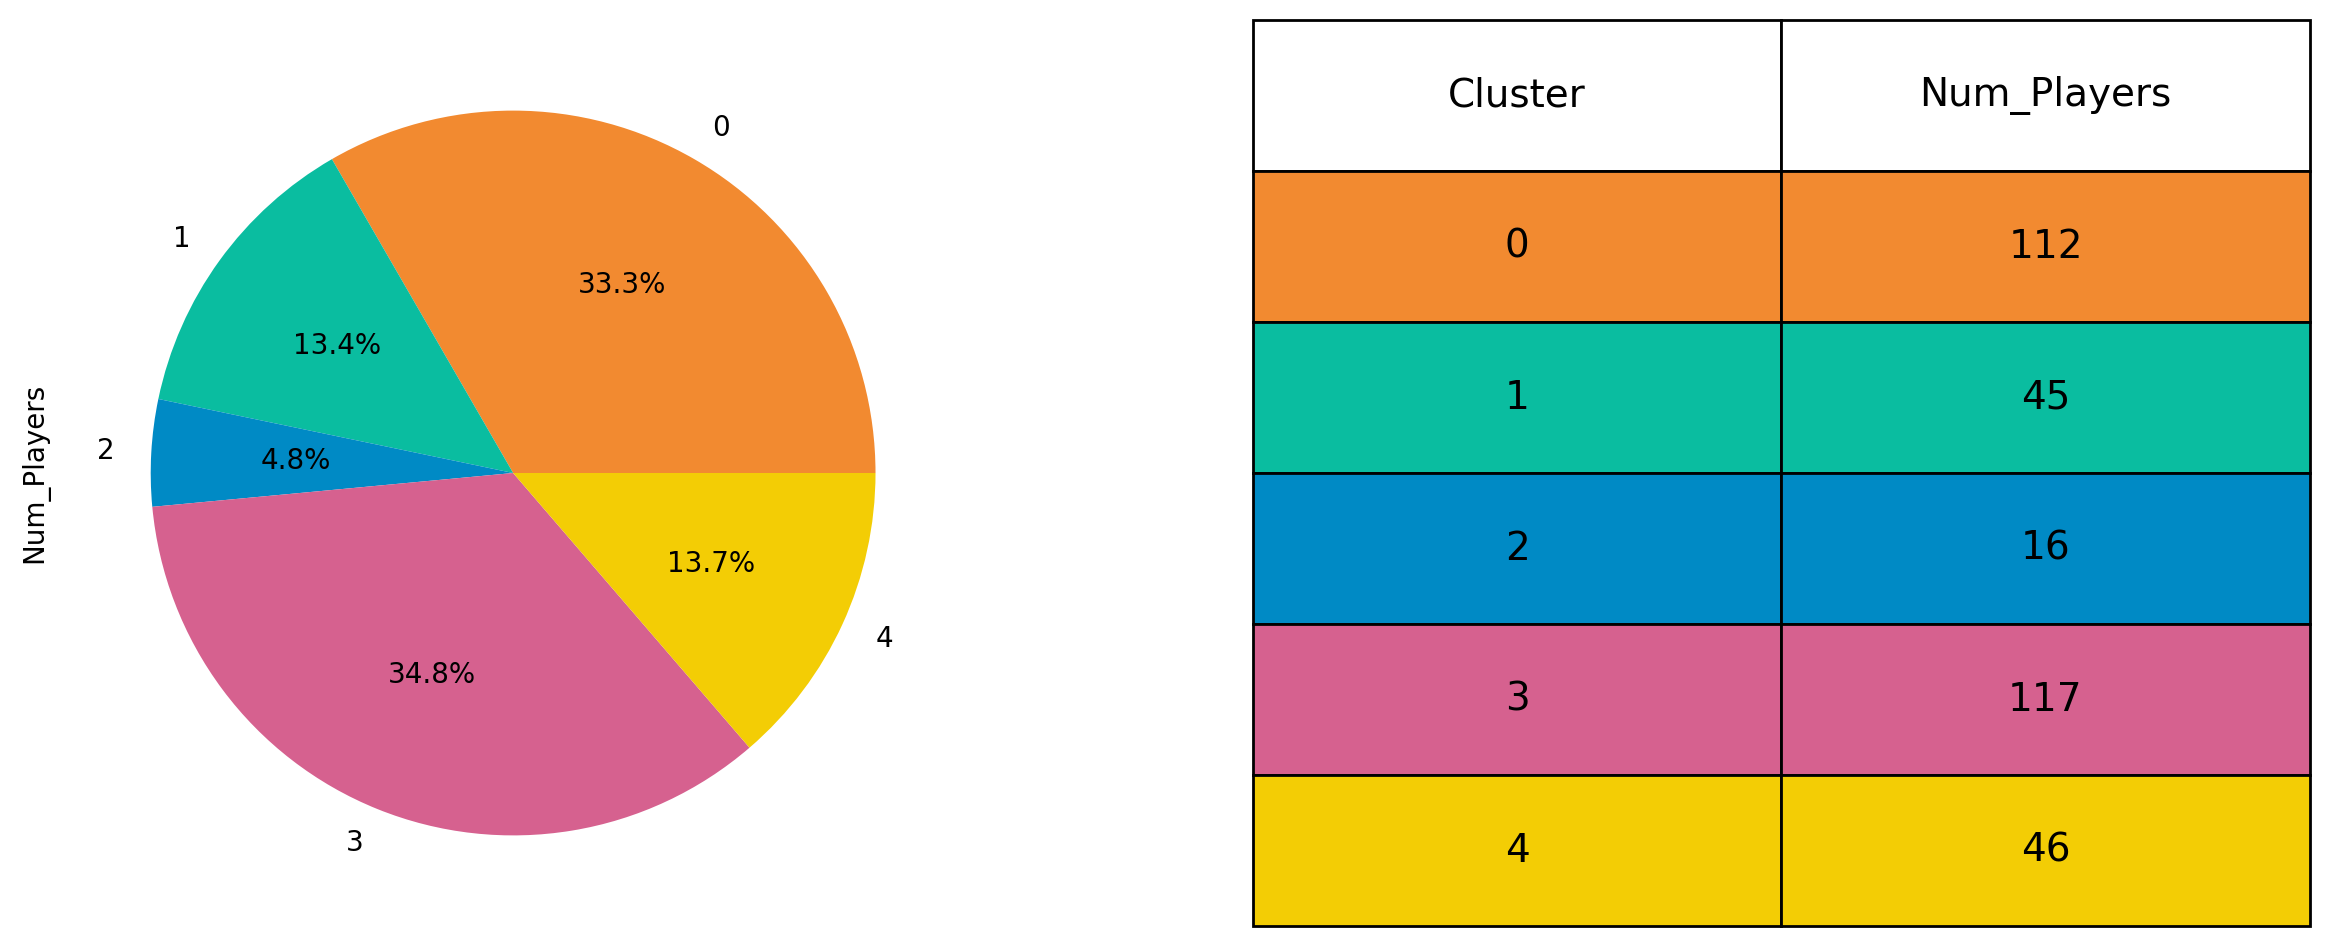

In [56]:

# View the summary of the clustering
clustering_summary(kmeans_label)

In [57]:
clustering_data(kmeans_label)


-----------------------
PLAYERS IN EACH CLUSTER
-----------------------



# Hierarchical Clustering

## Dendogram

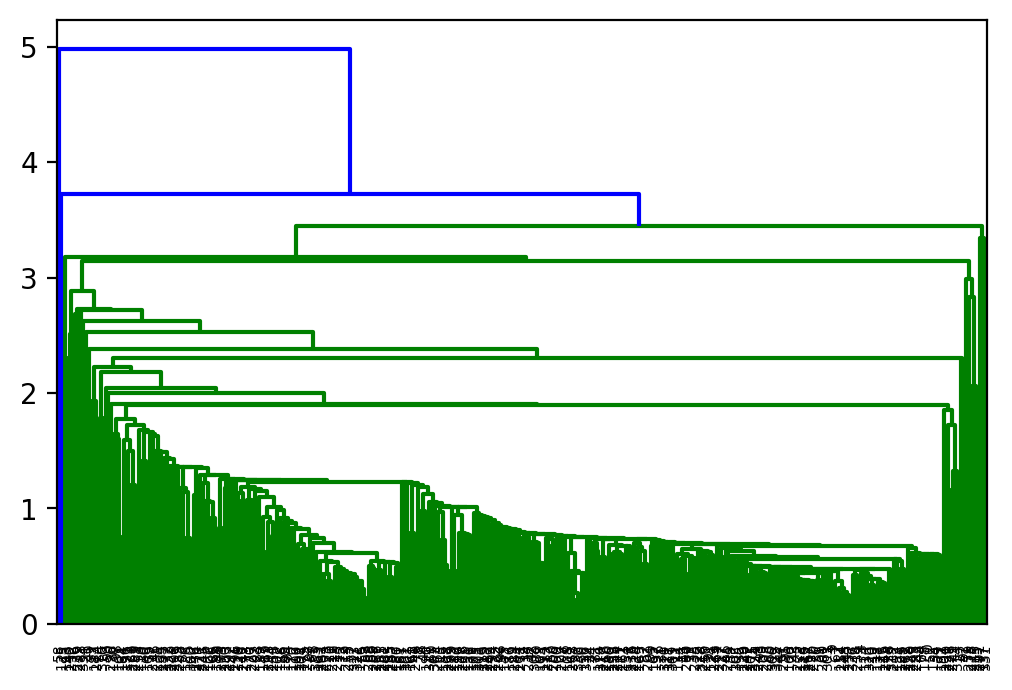

In [58]:
# single linkage
mergings = linkage(players_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

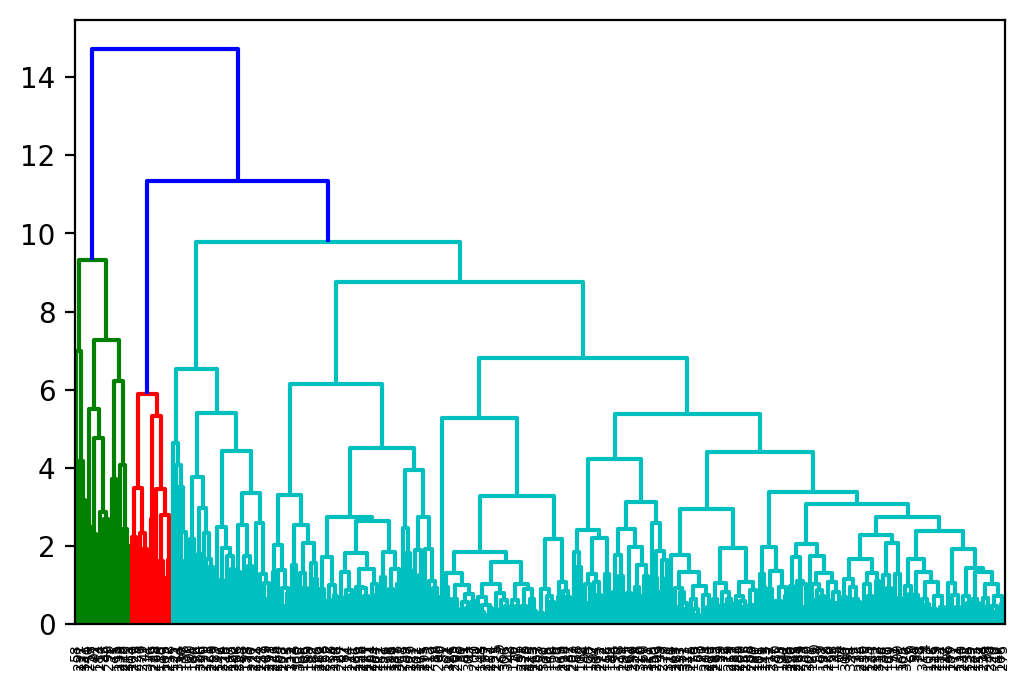

In [59]:
# complete linkage
mergings = linkage(players_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

## Hierarchical clustering

In [60]:
# Perform hierarchical clustering based on the input parameters
def hierarchical_clustering(linkage_method, linkage_metric, num_clusters,input_df,output_df,output_col):
    mergings = linkage(input_df, method=linkage_method, metric=linkage_metric)
    cluster_labels = cut_tree(mergings, n_clusters=num_clusters).reshape(-1, )
    # assign cluster labels
    output_df[output_col] = cluster_labels
    return mergings

In [61]:
# # Linkage method could be single, complete, average, weighted, centroid, median, ward
# # Refer to: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

# mergings = hierarchical_clustering(linkage_method = "complete", linkage_metric = "euclidean", num_clusters = NUM_CLUSTERS, input_df = players_scaled[ALL_COLUMN_NAMES], output_df = players, output_col = "cluster_hier")
# dendrogram(mergings)
# plt.show()

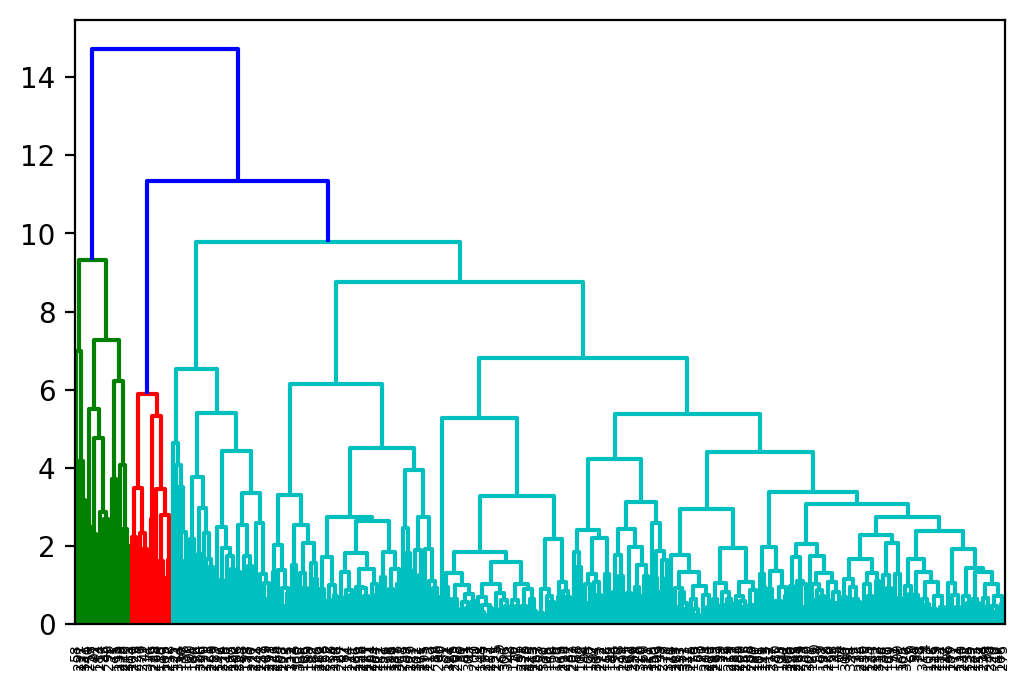

name  cluster_hier
0             Z Khan             0
1          YS Chahal             0
2           DW Steyn             0
265        RA Jadeja             1
266        PP Chawla             1
267  Harbhajan Singh             1
280        RG Sharma             2
281         SK Raina             2
282          V Kohli             2
296     Yuvraj Singh             3
297          M Vijay             3
298         V Sehwag             3
332        YK Pathan             4
333       KA Pollard             4
334        SR Watson             4

In [62]:
# New output column to create for the cluster label
hier_label = 'cluster_hier'


# Hierarchical clustering
# Linkage method could be single, complete, average, weighted, centroid, median, ward
# Refer to: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

mergings = hierarchical_clustering(linkage_method = "complete", linkage_metric = "euclidean", num_clusters = NUM_CLUSTERS, input_df = players_scaled[ALL_COLUMN_NAMES], output_df = players, output_col = "cluster_hier")
 
# Plot the dendogram
dendrogram(mergings)
plt.show()

# View few entries from each cluster
groupby_cluster(hier_label,3)

In [63]:
# # Create the cluster labels
# cluster_labels = cut_tree(mergings, n_clusters=NUM_CLUSTERS).reshape(-1, )# assign cluster labels
# players['cluster_hier'] = cluster_labels
# groupby_cluster("cluster_hier",2)


-----------------------
PLAYERS CLUSTER SUMMARY
-----------------------



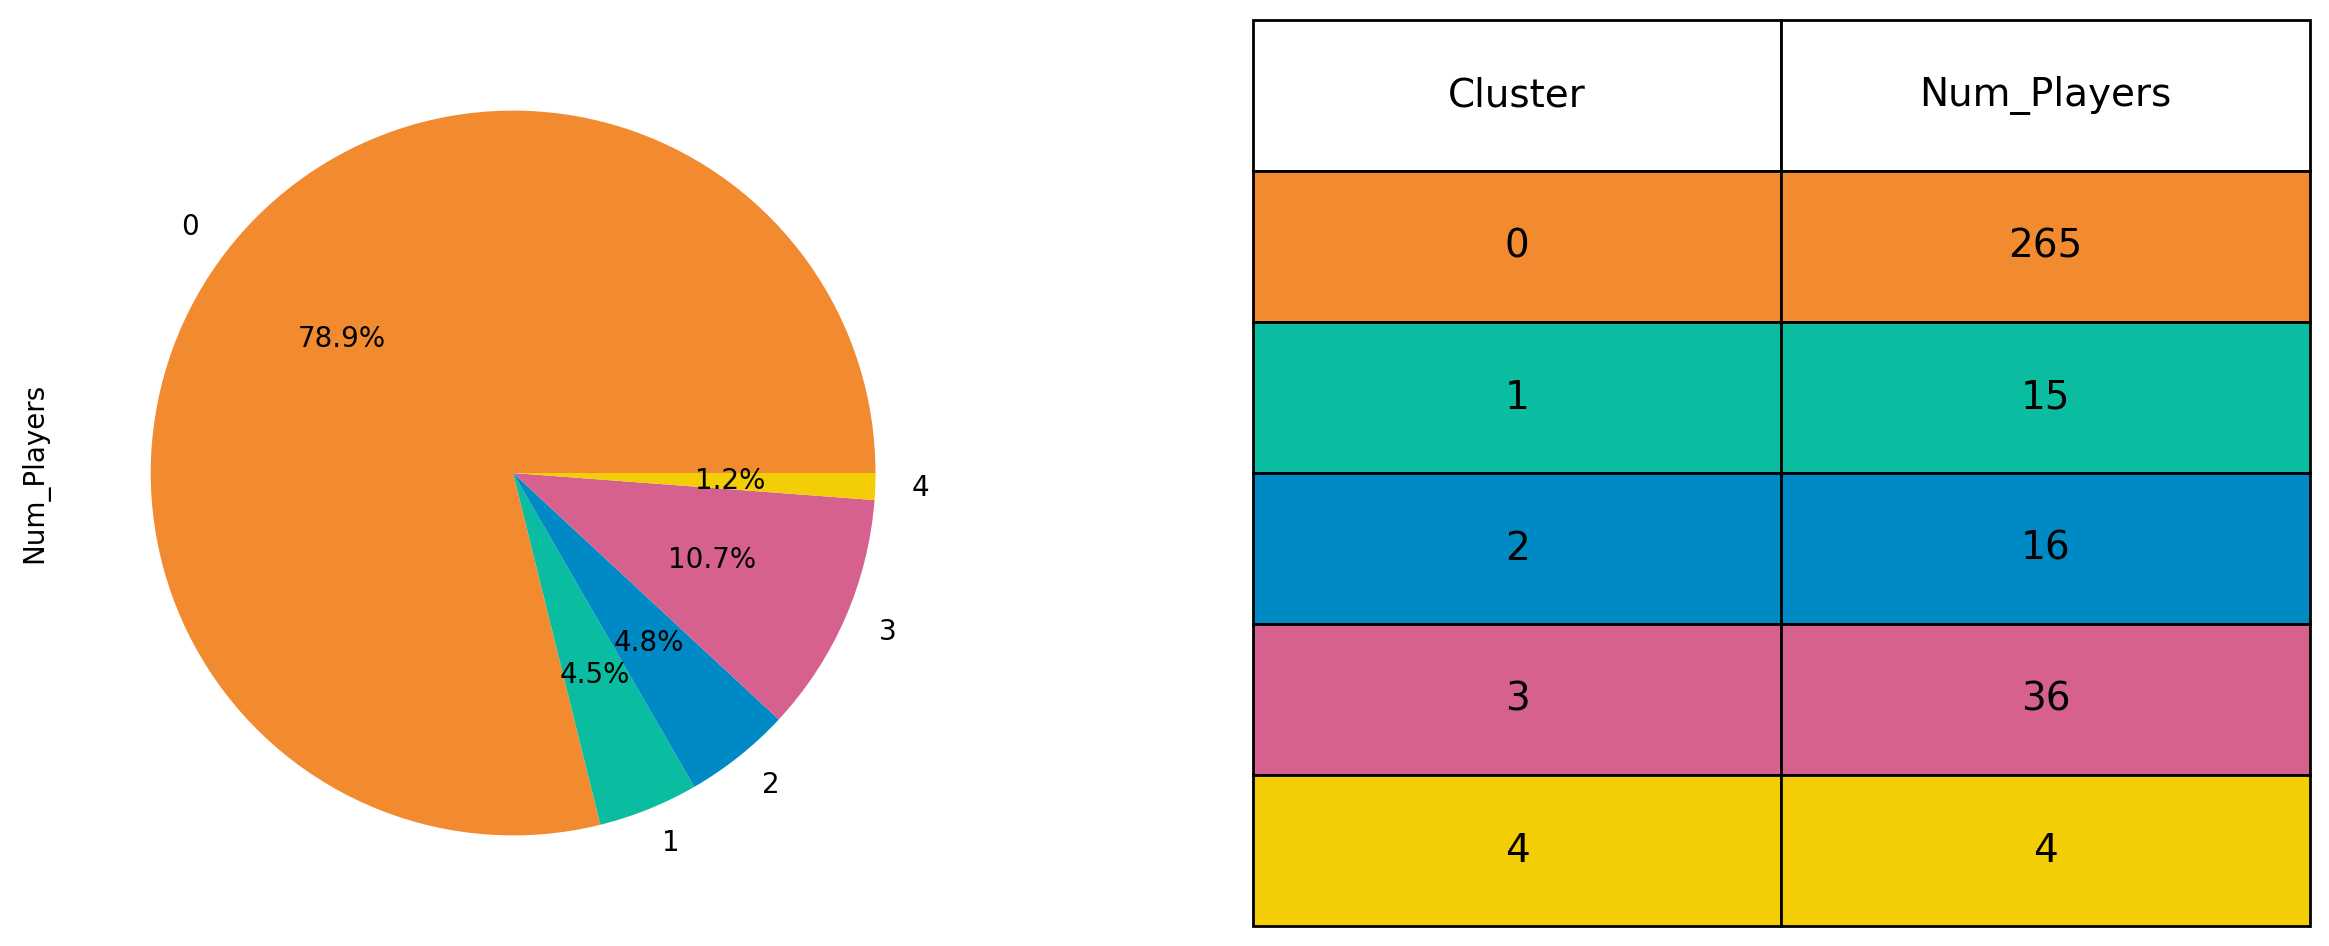

In [64]:
# View the summary of the clustering
clustering_summary(hier_label)

In [65]:
clustering_data(hier_label)


-----------------------
PLAYERS IN EACH CLUSTER
-----------------------




#  DBScan Clustering

Estimated number of clusters: 4
Estimated number of noise points: 129

-----------------------
PLAYERS CLUSTER SUMMARY
-----------------------



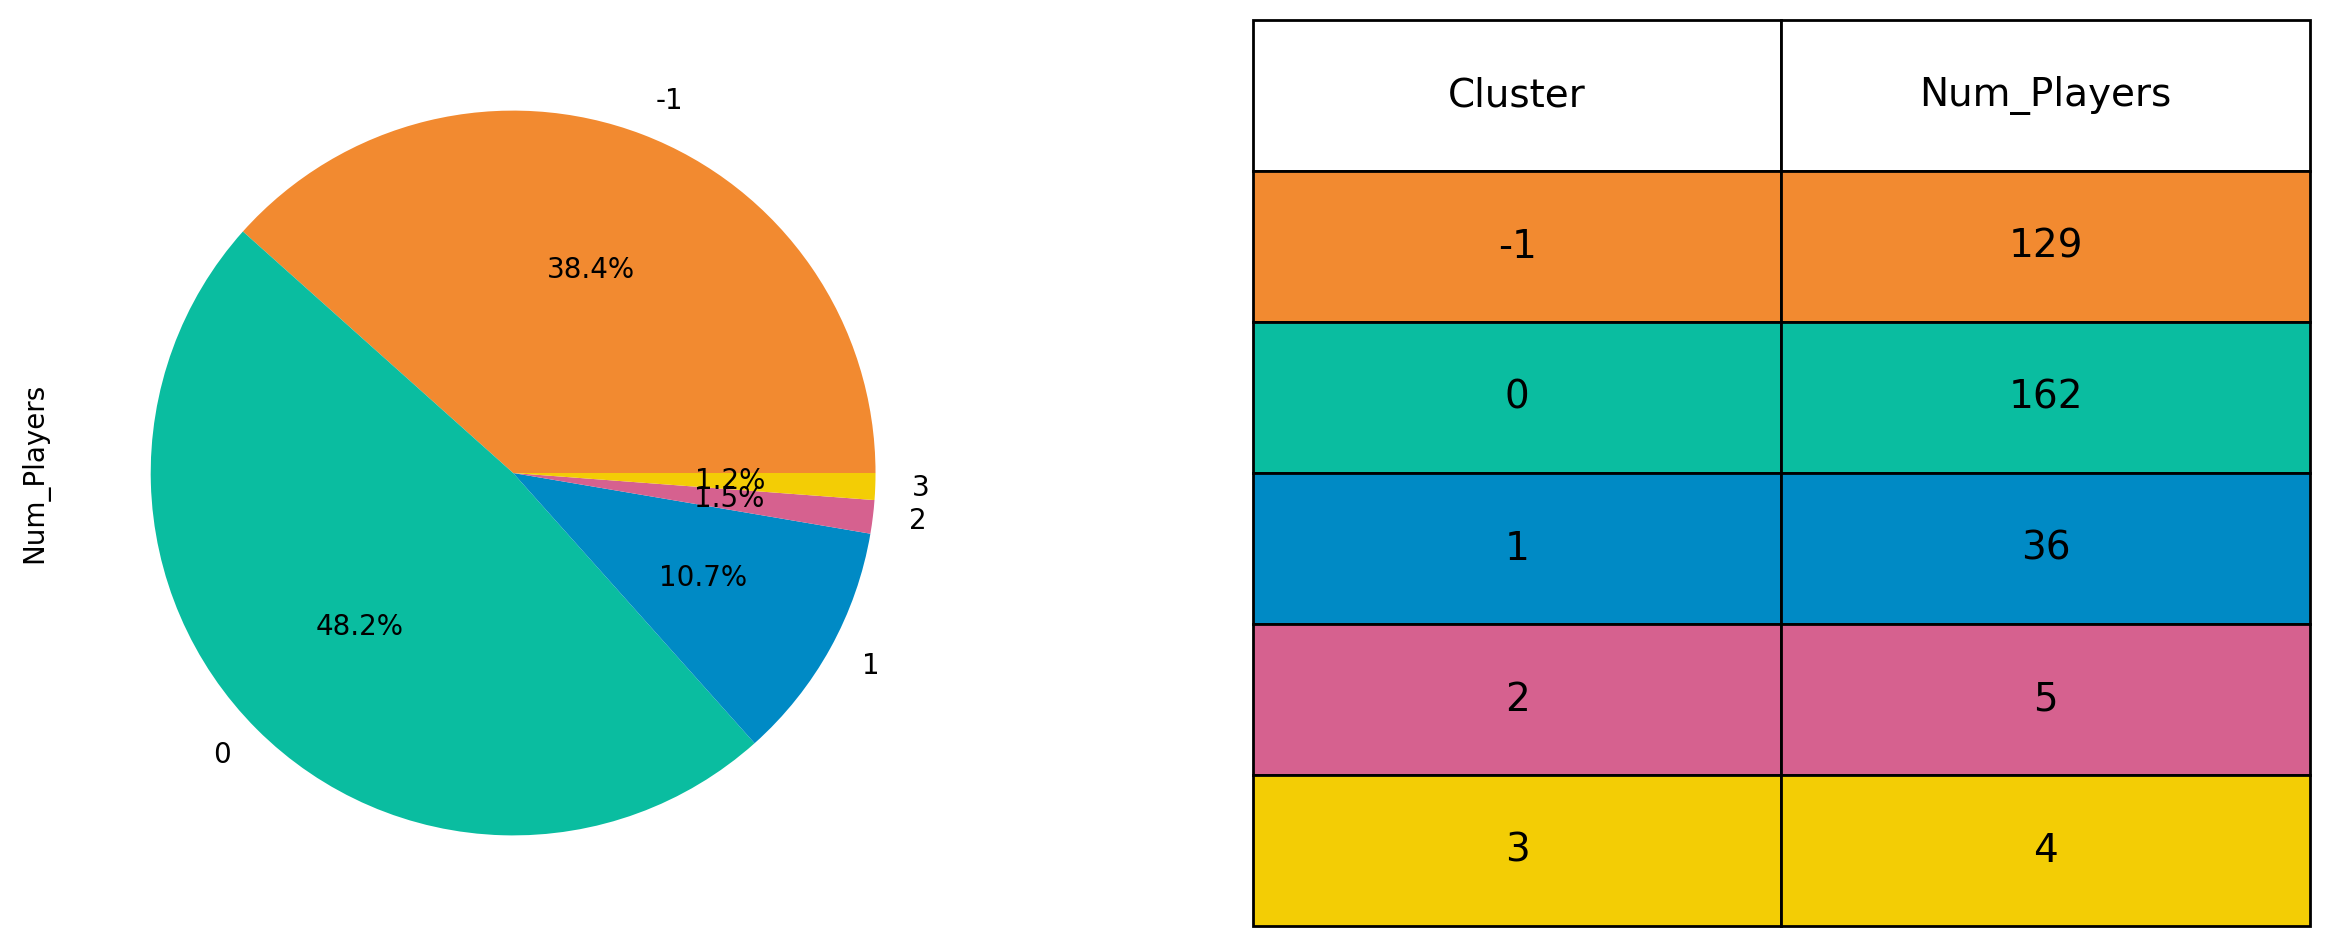

In [68]:
from sklearn.cluster import DBSCAN

# Perform density clustering based on the input parameters
db = DBSCAN(eps=0.9, min_samples=5).fit(players_scaled)

# Assign cluster labels
players["cluster_dbscan"] = db.labels_

# Number of clusters in labels, ignoring noise if present.
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

clustering_summary("cluster_dbscan")

In [69]:
# Perform density clustering based on the input parameters
def dbscan_clustering(epsilon, minimum_samples,input_df,output_df,output_col):
    # Compute DBSCAN
    db = DBSCAN(eps=epsilon, min_samples=minimum_samples).fit(input_df)
    labels = db.labels_

    # assign cluster labels
    output_df[output_col] = labels
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    #print('Estimated number of clusters: %d' % n_clusters_)
    #print('Estimated number of noise points: %d' % n_noise_)

In [70]:
# New output column to create for the cluster label
dbscan_label = 'cluster_dbscan'

# DBSCAN clustering
dbscan_clustering(0.9,3,players_scaled[ALL_COLUMN_NAMES],players,dbscan_label)

# View few entries from each cluster
groupby_cluster(dbscan_label,3)

name  cluster_dbscan
0         RG Sharma              -1
1          SK Raina              -1
2           V Kohli              -1
109       SB Jakati               0
110        M Kartik               0
111        DJ Hooda               0
273        AB Dinda               1
274      SK Trivedi               1
275        L Balaji               1
277    Ishan Kishan               2
278         M Vohra               2
279         CA Lynn               2
320     LRPL Taylor               3
321        CL White               3
322     RA Tripathi               3
323       KV Sharma               4
324        MM Patel               4
325  Mohammed Shami               4
329       SS Tiwary               5
330     S Badrinath               5
331         KK Nair               5
333       JJ Bumrah               6
334  Sandeep Sharma               6
335         A Nehra               6


-----------------------
PLAYERS CLUSTER SUMMARY
-----------------------



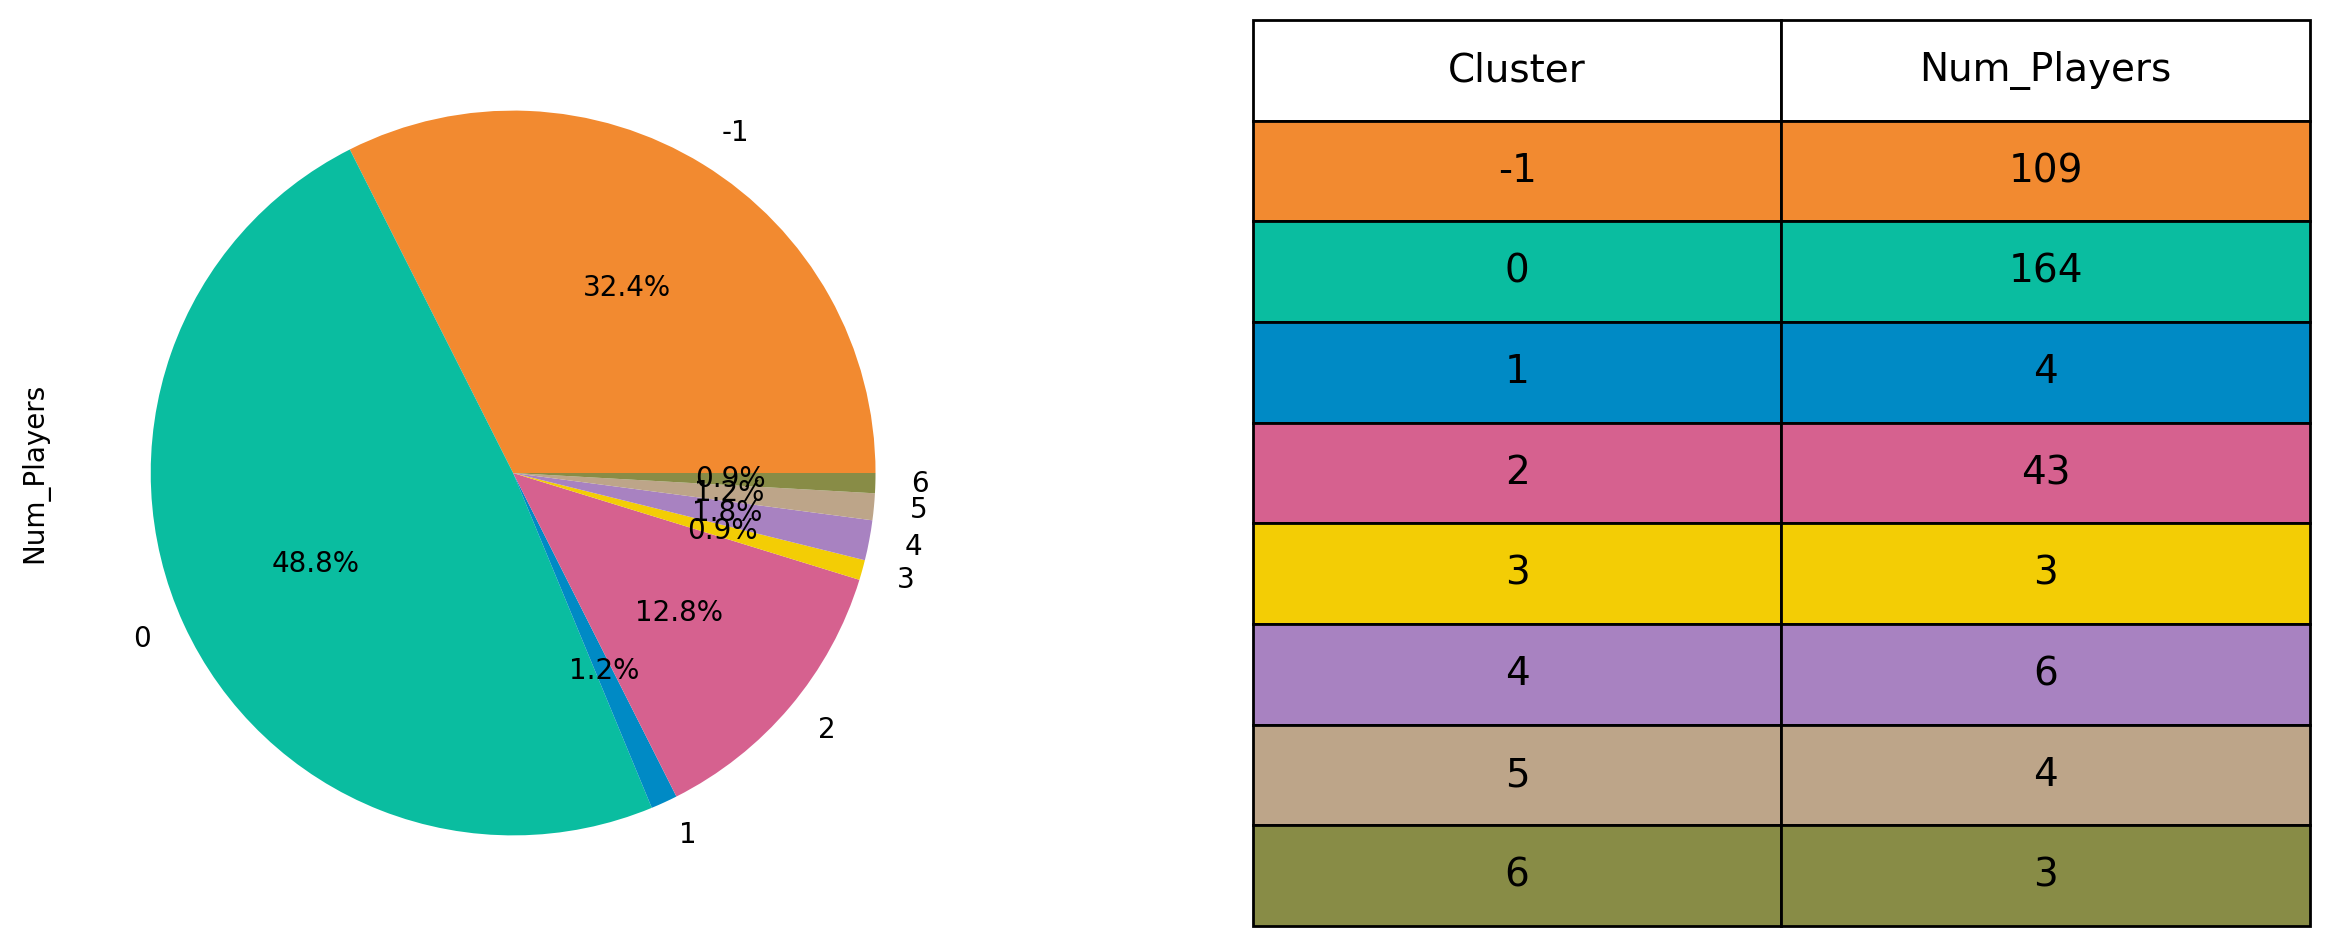

In [71]:

# View the summary of the clustering
clustering_summary(dbscan_label)

In [72]:
clustering_data(dbscan_label)


-----------------------
PLAYERS IN EACH CLUSTER
-----------------------



In [73]:
#dbscan_clustering(0.8,5,players_scaled[ALL_COLUMN_NAMES],players,"cluster_dbscan")

In [74]:
# # Compute DBSCAN
# db = DBSCAN(eps=0.3, min_samples=5).fit(players_scaled)
# labels = db.labels_

# # assign cluster labels
# players['cluster_dbscan'] = labels


In [75]:
# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)

# print('Estimated number of clusters: %d' % n_clusters_)
# print('Estimated number of noise points: %d' % n_noise_)

In [76]:
# groupby_cluster("cluster_dbscan",5)

# Comparing clustering results

In [77]:
print(f"K-means clustering with k={NUM_CLUSTERS}")
display(players['cluster_kmeans'].value_counts())
print(f"\nHierarchical clustering with k={NUM_CLUSTERS}")
display(players['cluster_hier'].value_counts())
print(f"\nDBScan clustering")
display(players['cluster_dbscan'].value_counts())

K-means clustering with k=5


3    117
0    112
4     46
1     45
2     16
Name: cluster_kmeans, dtype: int64


Hierarchical clustering with k=5


0    265
3     36
2     16
1     15
4      4
Name: cluster_hier, dtype: int64


DBScan clustering


 0    164
-1    109
 2     43
 4      6
 5      4
 1      4
 6      3
 3      3
Name: cluster_dbscan, dtype: int64

# Plots

## Runs vs Wickets

In [78]:
# Plotly scatter plot
def plot_clusters(x,y,cluster_col,size):
    color_dict = dict(zip(players[cluster_col].sort_values().unique(),CLUSTER_COLORS))
    fig = px.scatter(players, x=x,   y=y, color=cluster_col,
                     size=size, hover_data=['name'], title = f'Scatter Plot: {x} vs {y}, Size = {size}', color_discrete_map=color_dict)
    fig.show()

In [79]:
plot_clusters('runs','wickets','cluster_kmeans','catches')

In [80]:
plot_clusters('runs','wickets','cluster_hier','catches')

In [81]:
plot_clusters('runs','wickets','cluster_dbscan','catches')

In [82]:
# # Plotly scatter plot
# fig = px.scatter(players, x="runs",   y="wickets", color="cluster_kmeans",
#                  size='catches', hover_data=['name'], title = 'Scatter Plot: Runs vs Wickets, Size = catches', color_discrete_sequence=px.colors.qualitative.Light24)
# fig.show()

# # color_discrete_sequence - https://plotly.com/python/discrete-color/

## Seaborn - scatter plots

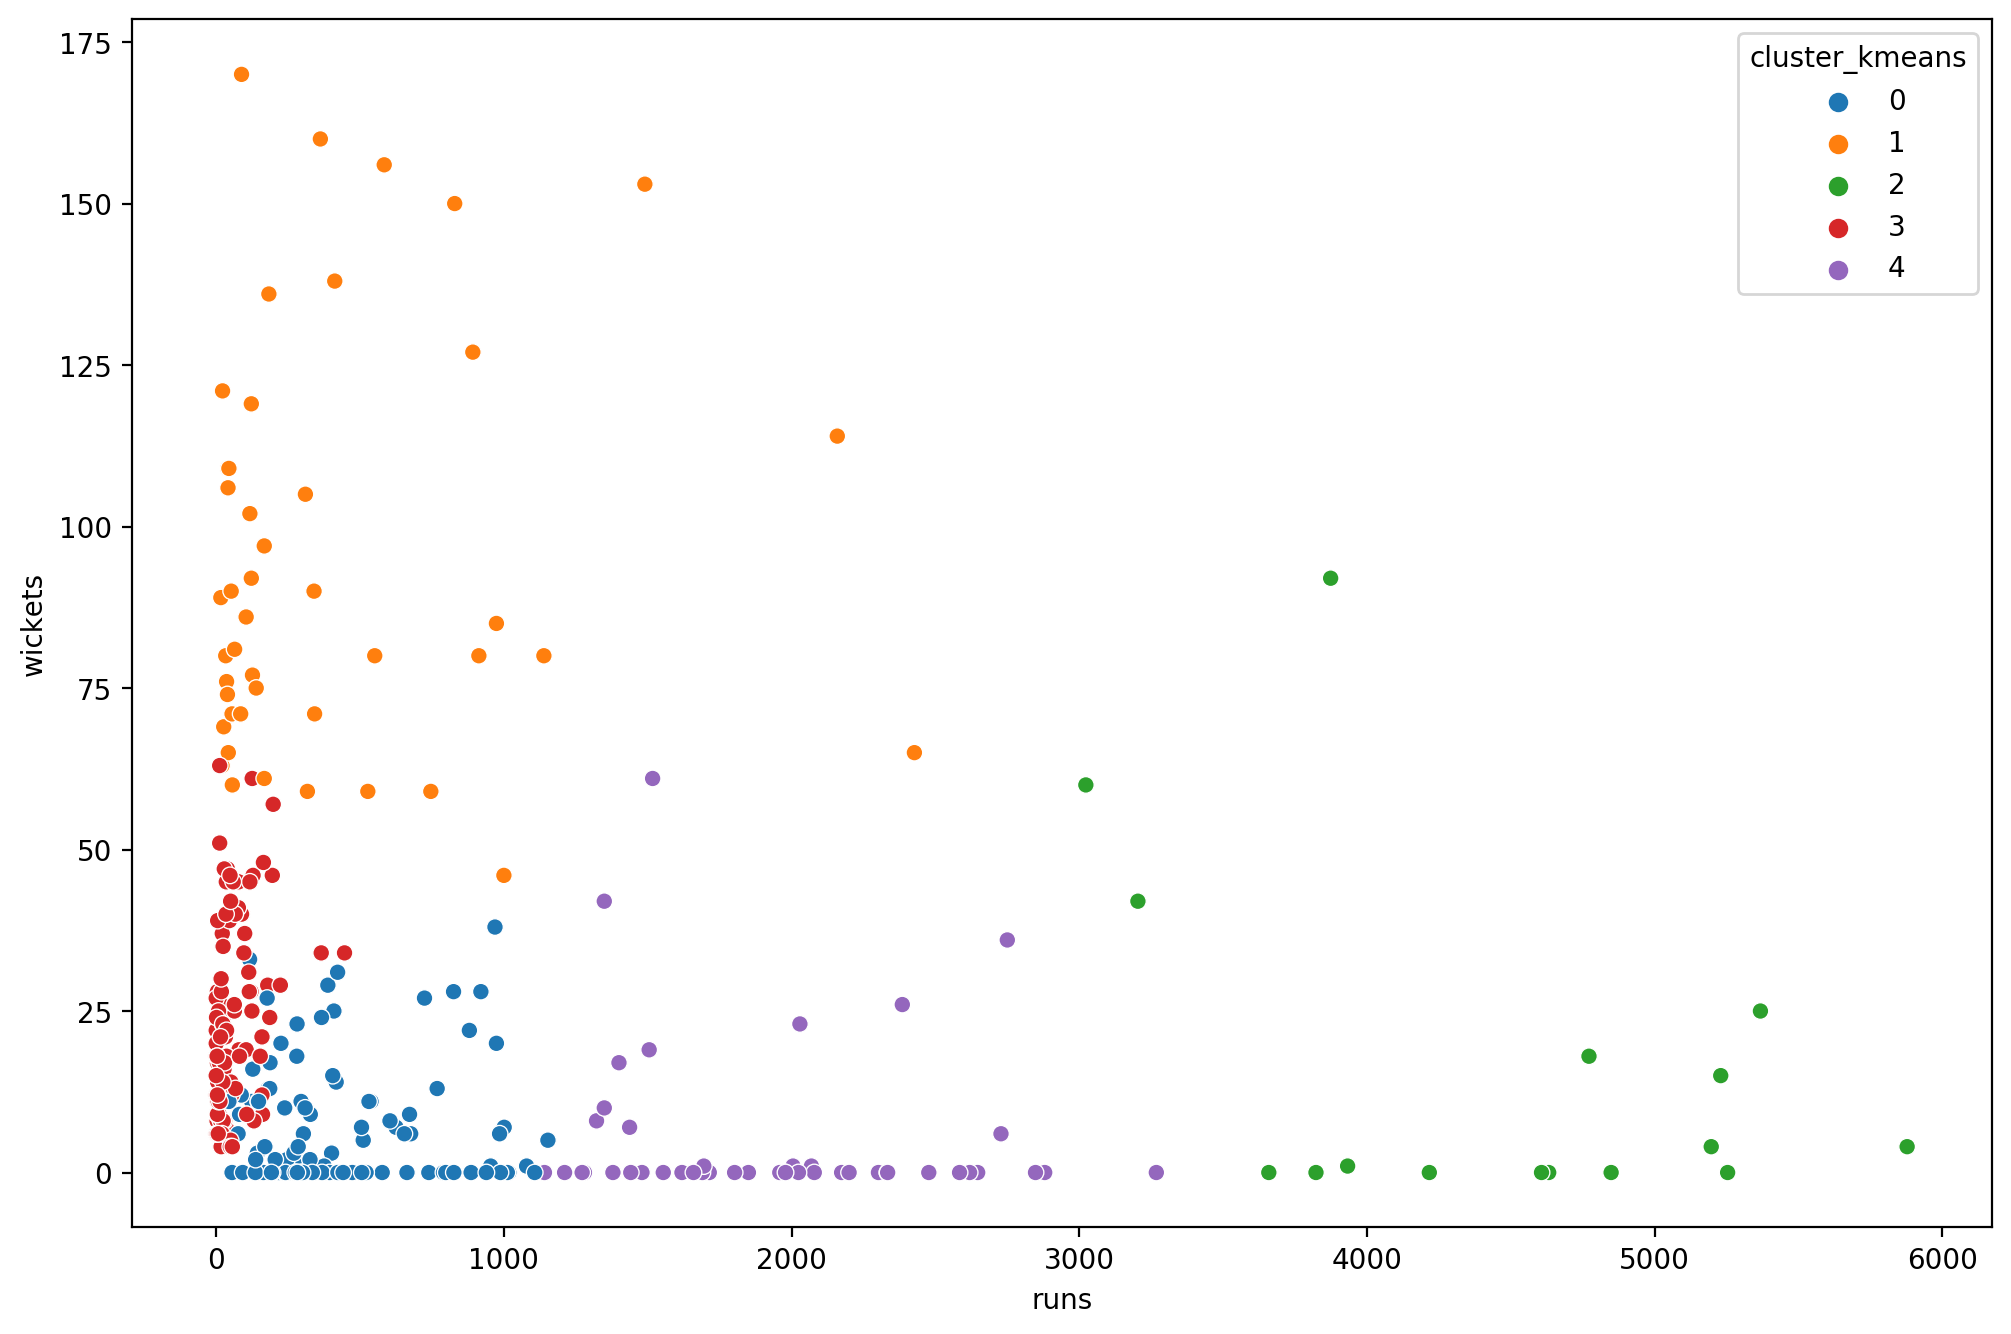

In [83]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="runs",   y="wickets", hue="cluster_kmeans", data=players, palette="tab10")

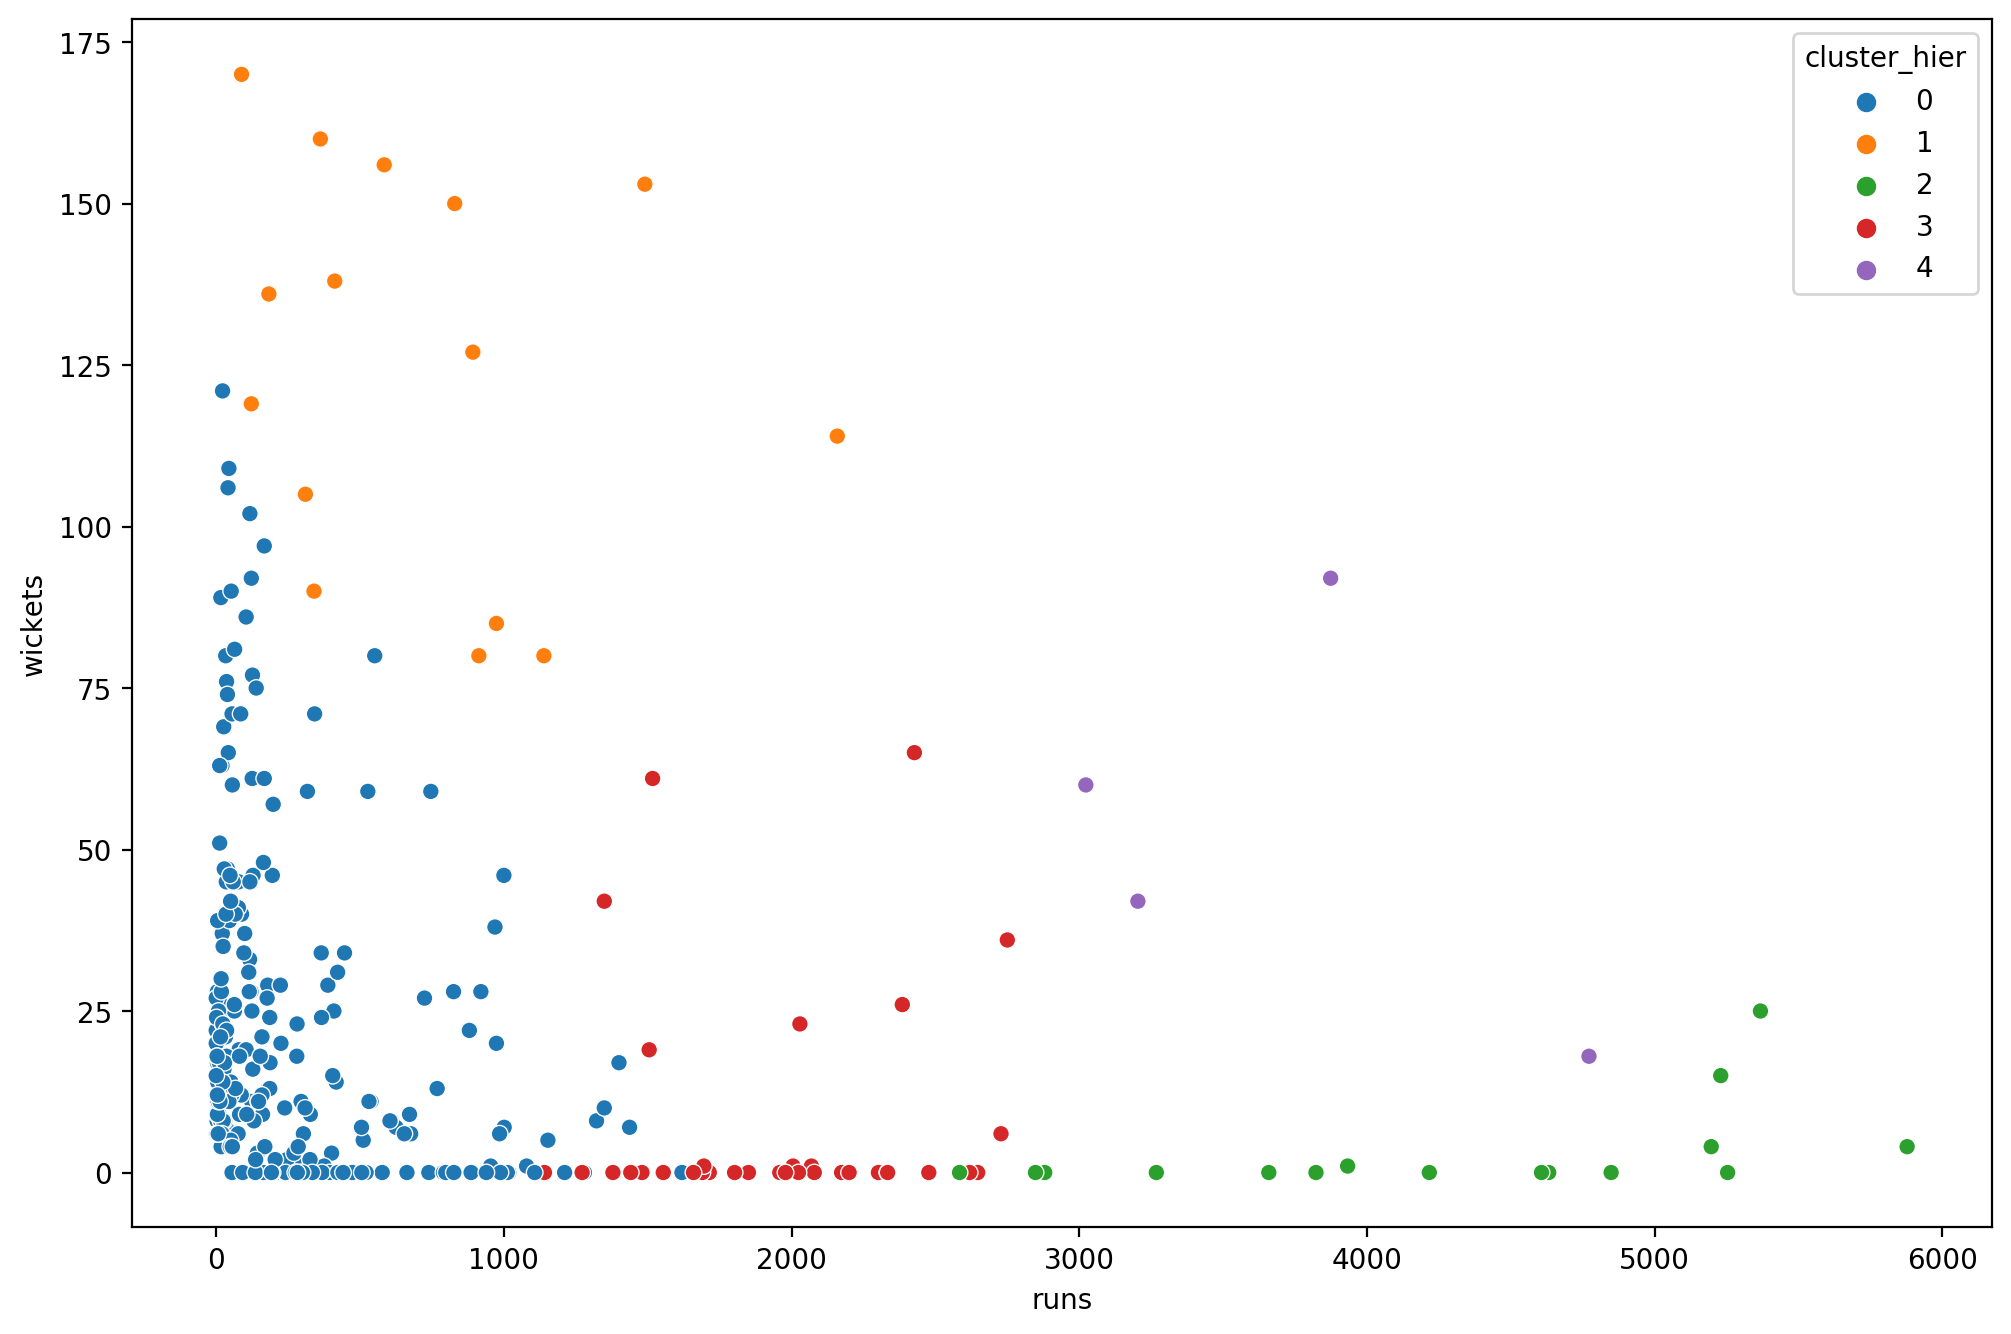

In [84]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="runs",   y="wickets", hue="cluster_hier", data=players, palette="tab10")

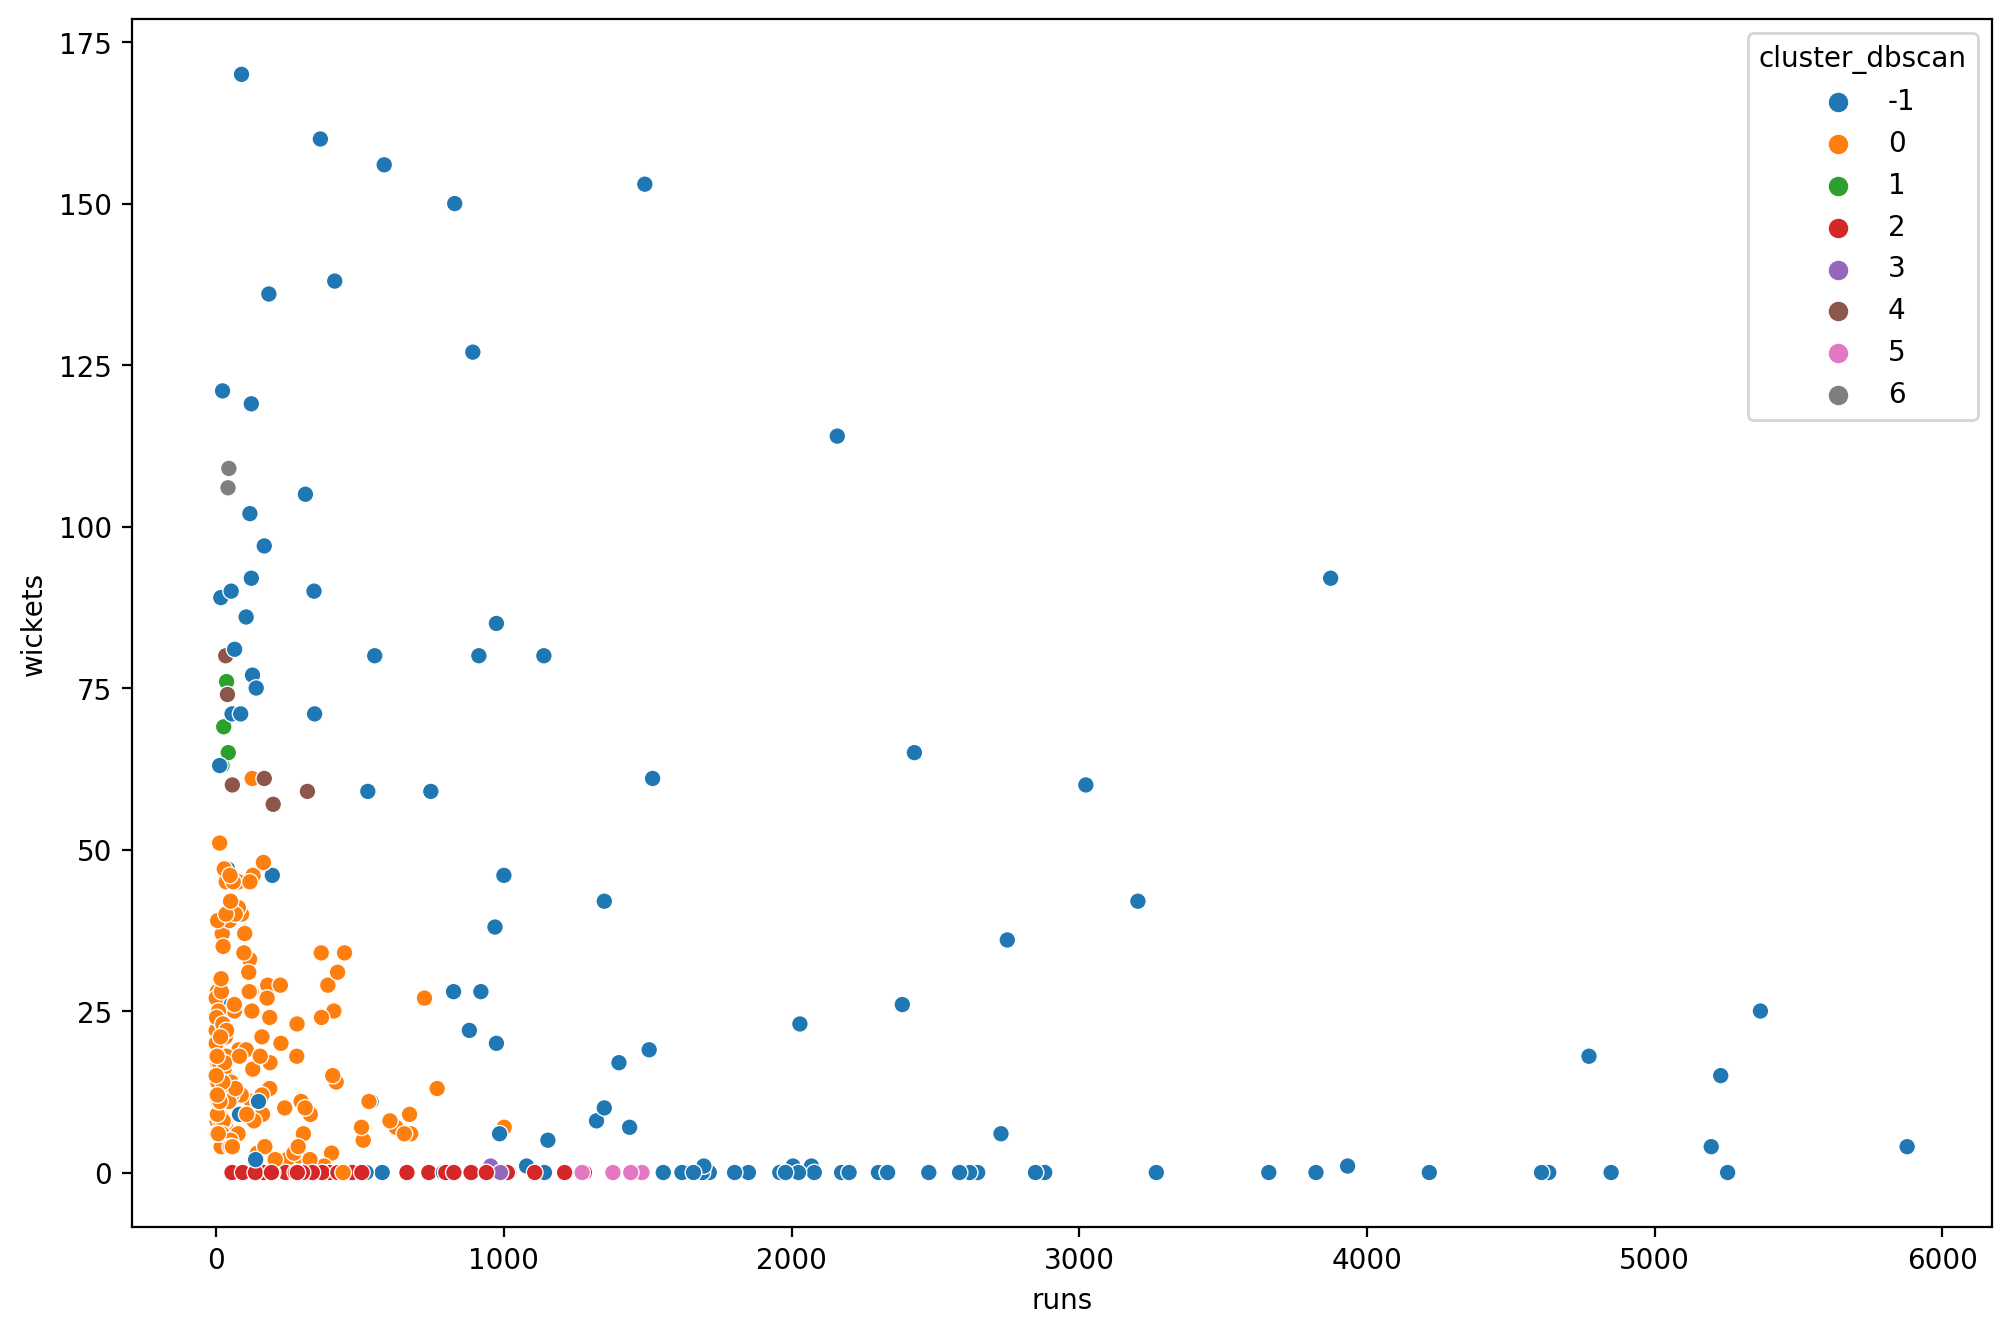

In [85]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="runs",   y="wickets", hue="cluster_dbscan", data=players, palette="tab10")

## Runs vs catches

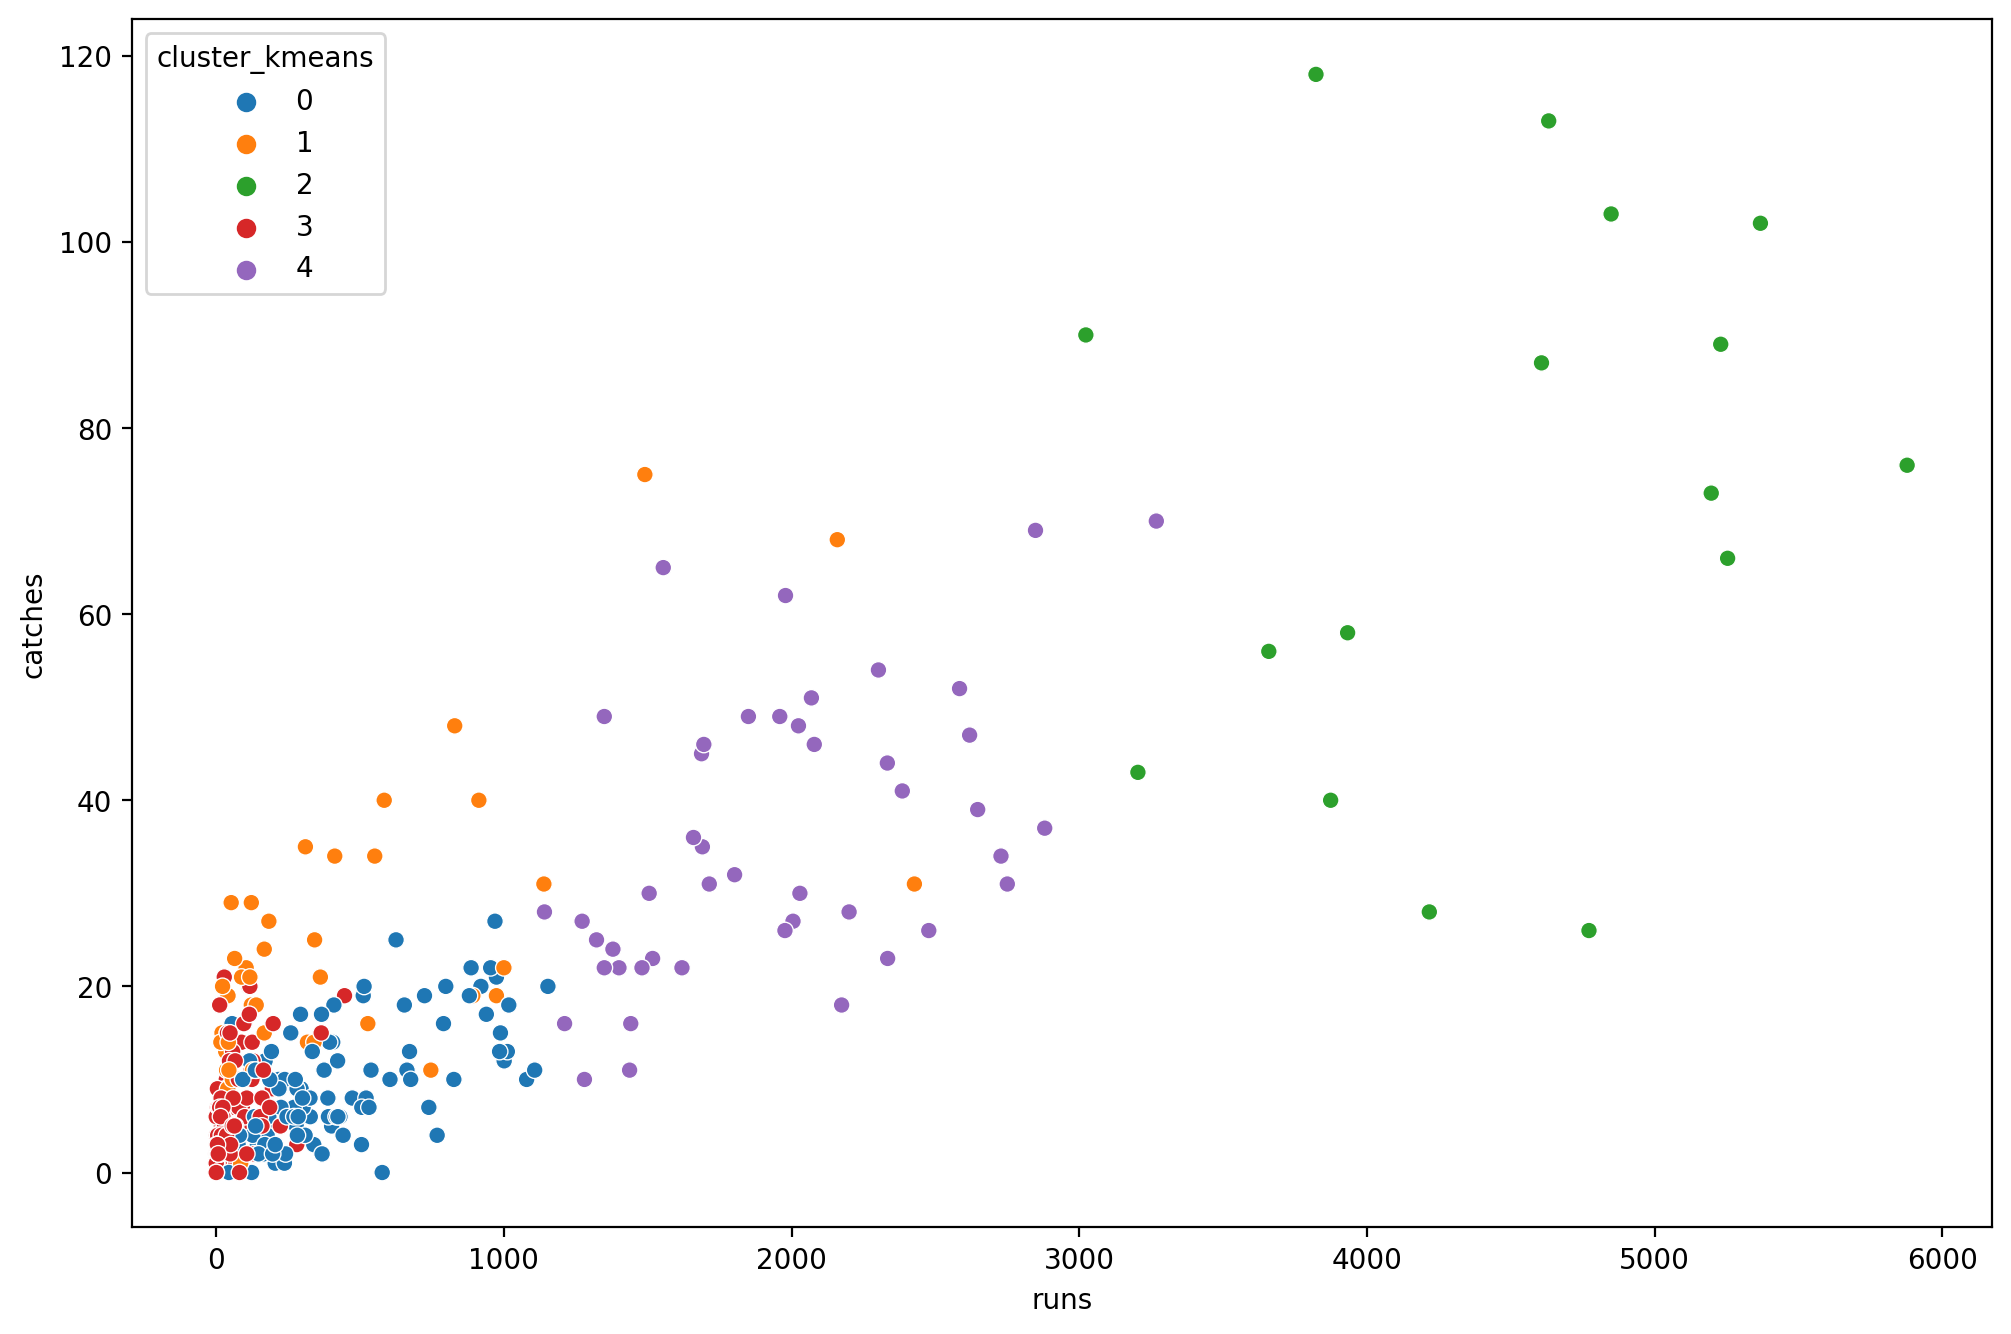

In [86]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="runs",   y="catches", hue="cluster_kmeans", data=players, palette="tab10")

# Only runs & wickets

In [87]:
cols = ['bat_average','bowl_econ']

In [88]:
# final model with k=3
kmeans = KMeans(n_clusters=NUM_CLUSTERS, max_iter=50)
kmeans.fit(players_scaled[cols])

# assign the label
players['cluster_kmeans_small'] = kmeans.labels_


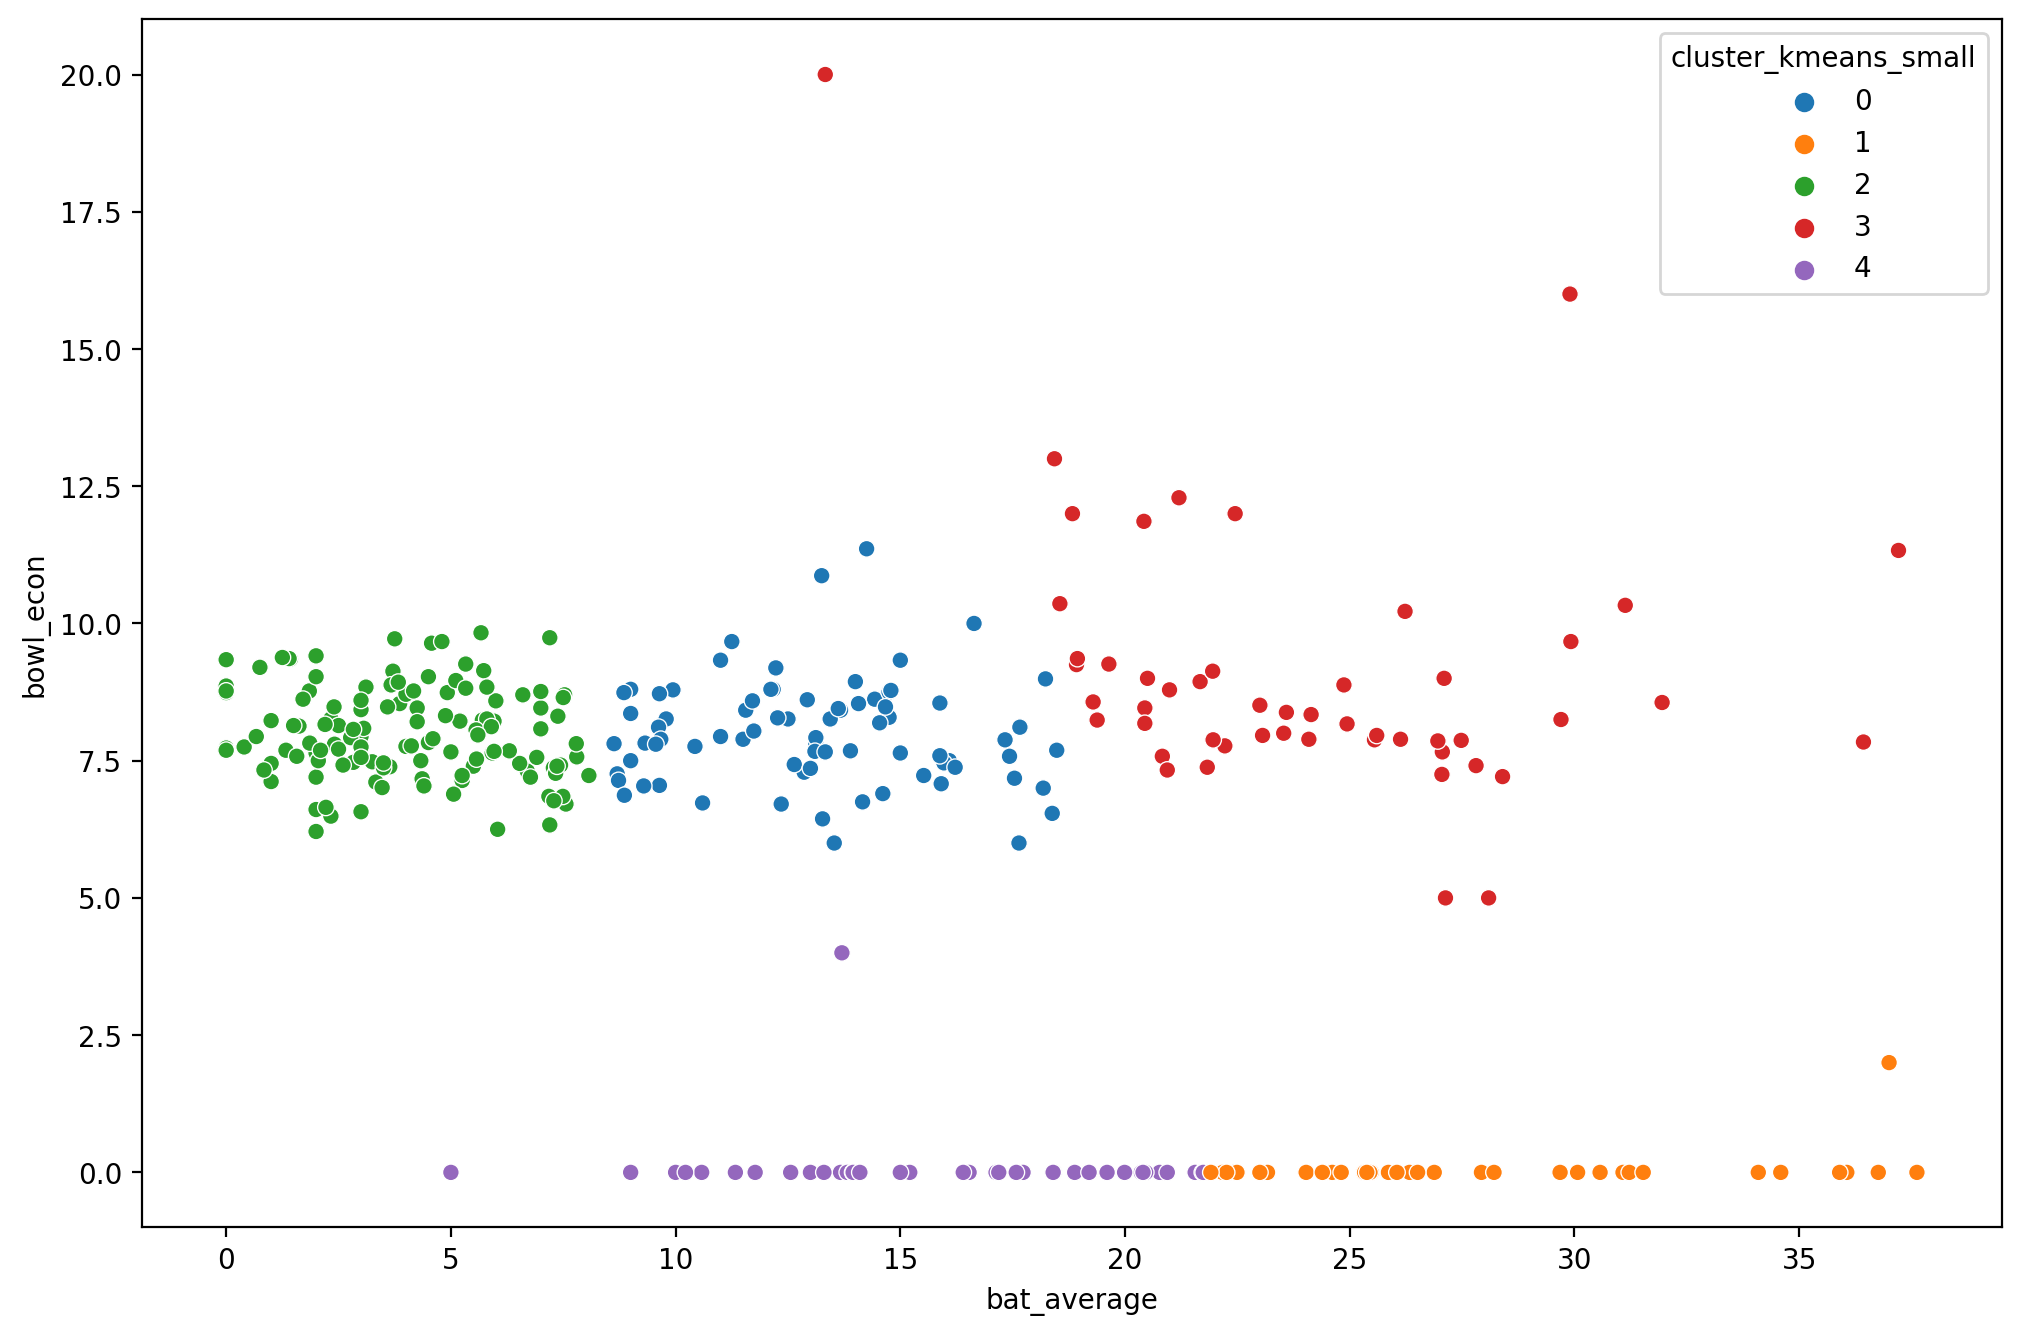

In [89]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="bat_average",   y="bowl_econ", hue="cluster_kmeans_small", data=players, palette="tab10")

In [90]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=5).fit(players_scaled[cols])
labels = db.labels_

# assign cluster labels
players['cluster_dbscan_avgecon'] = labels

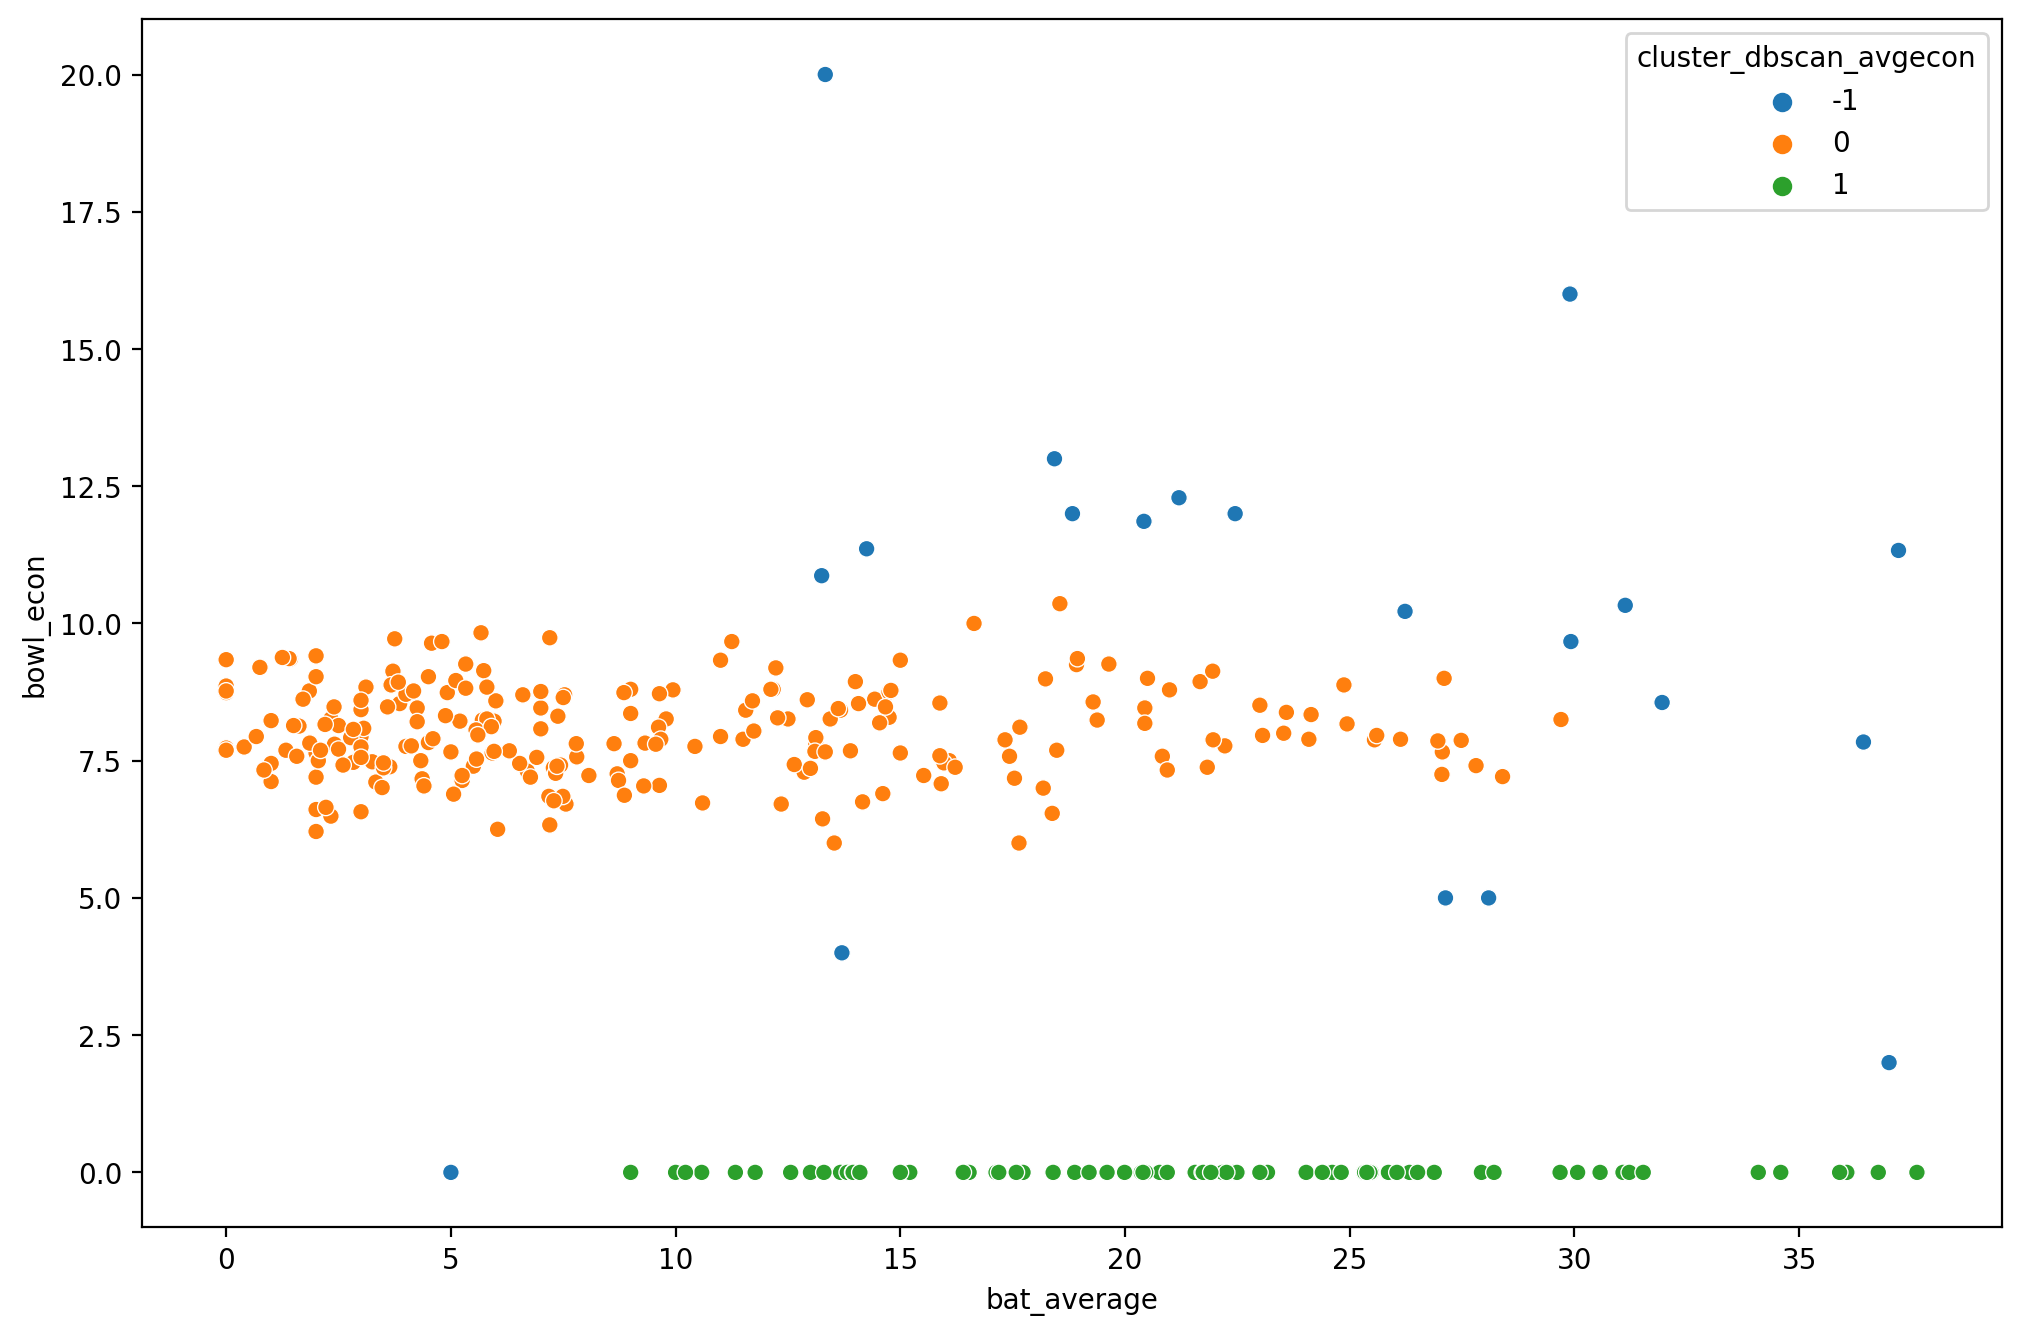

In [91]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="bat_average",   y="bowl_econ", hue="cluster_dbscan_avgecon", data=players, palette="tab10")

# References

In [92]:
# https://www.linkedin.com/pulse/ai-daily-life-clustering-cricket-players-ramachandran-s/
    

# WIDGETS

In [93]:
# Default Values
CLUSTERING_TECHNIQUE = 'K-MEANS CLUSTERING'
CLUSTER_COLS = ALL_COLUMN_NAMES
CLUSTER_OUTPUT_COL = 'output_kmeans'
#NUM_CLUSTERS = 5
HIERARCHICAL_LINKAGE = 'complete'
#b_with_kvalue = True
b_kmeans_clustering = True
b_hier_clustering = False
b_dbscan_clustering = False

PLOT_X = 'runs'
PLOT_Y = 'wickets'
PLOT_SIZE = 'catches'

In [94]:
def display_clustering_description(cluster_technique):
    print(cluster_technique)
    print('-' * len(cluster_technique))
    if(cluster_technique == 'K-MEANS CLUSTERING'):
        print("- K-means is a centroid-based clustering algorithm")
        print("- It requires a pre-specified no. of clusters (k)")
        print("- The points are clustered based on the similarity (usually Euclidian Distance)")
        print("- Check out the 'Cluster Analysis' tab to find the optimal number of clusters")
        print("\n")
    elif(cluster_technique == 'HIERARCHICAL CLUSTERING'):
        print("- Hierarchical clustering builds nested clusters by merging points successively")
        print("- Hierarchical methods can be  either divisive or agglomerative")
        print("- The hierarchy of clusters is represented as a tree diagram known as dendrogram")
        print("- The linkage method defines the distance/similarity calculation")
        print("\n")
    elif(cluster_technique == 'DBSCAN CLUSTERING'):
        print("- DBSCAN: Density-Based Spatial Clustering of Applications with Noise")
        print("- DBSCAN groups together points that are closely packed together")
        print("- It marks points in low-density regions as outliers (noise)")
        print("- DBSCAN requires two key parameters: \n    1. Epsilon: radius to define the neighborhood around a point\n    2. Minimum Points: min neighbors within epsilon radius to form a dense region")
        print("\n")
    else:
        print("INVALID CLUSTERING TECHNIQUE!!")

In [105]:


############## Initialize Widgets ###################

w_ctechnique = widgets.RadioButtons(options=['K-MEANS CLUSTERING', 'HIERARCHICAL CLUSTERING', 'DBSCAN CLUSTERING'],
                                         value=CLUSTERING_TECHNIQUE, description='',
                                         layout={'width': 'max-content'}, 
                                         style={'description_width': 'initial'}, disabled=False)



# config_layout = widgets.Layout(  width='auto', height='40px',justify_content='space-between',display='flex',
#     flex_flow='column', align_items='stretch' )



# K-means Clustering Configurations


# No. of clusters
w_kvalue_kmeans = widgets.BoundedIntText(value=5, min=2, max=10, step=1, description='', disabled=not b_kmeans_clustering )

w_max_iter = widgets.BoundedIntText(
    value=50, min=2, max=1000, step=5, description='', disabled=not b_kmeans_clustering)

# Hierarchical Clustering Configurations
# No. of clusters
w_kvalue_hier = widgets.BoundedIntText(value=5, min=2, max=10, step=1, description='', disabled=not b_hier_clustering )

#Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
w_linkage = widgets.Dropdown(options=['single', 'complete', 'average','weighted', 'centroid', 'median','ward'],
                                         value=HIERARCHICAL_LINKAGE, description='',
                                         style={'description_width': 'initial'}, disabled=not b_hier_clustering)

# DBSCAN Clustering Configurations
w_epsilon = widgets.FloatSlider(
    value=0.9, min=0, max=5.0, step=0.1, description='',
    disabled=not b_dbscan_clustering, continuous_update=False, orientation='horizontal',
    readout=True, readout_format='.1f',
    visibility = False
)

w_minpoints = widgets.IntSlider(
    value=5, min=2, max=20, step=1, description='', disabled=not b_dbscan_clustering,
    visibility = False )


# Variables selection
multiselect_layout = widgets.Layout(width='40%')
w_ccolumns = widgets.SelectMultiple(options=ALL_COLUMN_NAMES, description='',
                                        value=CLUSTER_COLS,
                                        rows=len(ALL_COLUMN_NAMES),
                                        #layout=widgets.Layout(width="flex"),
                                        #layout={'width': 'max-content'}, 
                                        #layout=widgets.Layout(display="flex", flex_flow='column'),
                                    layout=widgets.Layout(border='solid', width="50%",display="flex", justify_content="flex-end"),
                                        style={'description_width': 'initial'}, disabled=False)


                                         
button_layout = widgets.Layout(display='flex', flex_flow='column', align_items='stretch', border='solid',
                               width='40%', height='40px')
wbtn_cluster_data = widgets.Button(description="CLUSTER PLAYERS", disabled=False, layout=button_layout,
                                     visibility="visible", button_style="success")

# Scatter plot selection


w_plot_x = widgets.Dropdown(options=ALL_COLUMN_NAMES,
                                         value=PLOT_X, description='',
                                         layout={'width': 'max-content'}, 
                                         style={'description_width': 'initial'}, disabled=False)

w_plot_y = widgets.Dropdown(options=ALL_COLUMN_NAMES,
                                         value=PLOT_Y, description='',
                                         layout={'width': 'max-content'}, 
                                         style={'description_width': 'initial'}, disabled=False)

w_plot_size = widgets.Dropdown(options=ALL_COLUMN_NAMES,
                                         value=PLOT_SIZE, description='',
                                         layout={'width': 'max-content'}, 
                                         style={'description_width': 'initial'}, disabled=False)
wbtn_plot_now = widgets.Button(description="PLOT NOW", disabled=False, layout=button_layout,
                                     visibility="visible", button_style="WARNING")

# Cluster Analysis
w_min_k = widgets.BoundedIntText(
    value=2, min=2, max=20, step=1, description='',layout={'width': 'max-content'}, disabled=False)


w_max_k = widgets.BoundedIntText(
    value=10, min=w_min_k.value, max=20, step=1, description='',layout={'width': 'max-content'}, disabled=False)

w_max_iter_analysis = widgets.BoundedIntText(
    value=50, min=2, max=1000, step=5, description='',layout={'width': 'max-content'}, disabled=False)

wbtn_elbow = widgets.Button(description="ELBOW METHOD", disabled=False, layout=button_layout,
                                     visibility="visible", button_style="WARNING")

wbtn_silhouette = widgets.Button(description="SILHOUETTE SCORE", disabled=False, layout=button_layout,
                                     visibility="visible", button_style="WARNING")

#wbtn_optimal_k = widgets.Button(description="FIND OPTIMAL K", disabled=False,
#                                       layout=button_layout,
#                                       visibility="visible", button_style="success")
output_clusters = widgets.Output(layout=widgets.Layout(border='solid', width='100%'))
output_plot = widgets.Output(layout=widgets.Layout(border='solid', width='100%'))
output_summary = widgets.Output(layout=widgets.Layout(border='solid', width='100%'))
output_all_stats = widgets.Output(layout=widgets.Layout(border='solid', width='100%'))
output_analysis = widgets.Output(layout=widgets.Layout(border='solid', width='100%')) 
output_desc = widgets.Output(layout=widgets.Layout( width="75%",display="flex", justify_content="flex-end"))    


############## Observe Widgets ###################
def create_clusters(): 
    global CLUSTER_OUTPUT_COL
    if(w_ctechnique.value == 'K-MEANS CLUSTERING'):
        CLUSTER_OUTPUT_COL = 'output_kmeans'
        kmeans_clustering(w_kvalue_kmeans.value,w_max_iter.value,players_scaled[CLUSTER_COLS],players,CLUSTER_OUTPUT_COL)
    elif(w_ctechnique.value == 'HIERARCHICAL CLUSTERING'):
        LINKAGE_METRIC = 'euclidean'  
        CLUSTER_OUTPUT_COL = 'output_hier'
        mergings = hierarchical_clustering(w_linkage.value, LINKAGE_METRIC, w_kvalue_hier.value, players_scaled[CLUSTER_COLS],players,CLUSTER_OUTPUT_COL)      
    elif(w_ctechnique.value == 'DBSCAN CLUSTERING'):
        CLUSTER_OUTPUT_COL = 'output_dbscan'
        dbscan_clustering(w_epsilon.value,w_minpoints.value,players_scaled[CLUSTER_COLS],players,CLUSTER_OUTPUT_COL)
    
    # Add prefix 'cluster' to cluster numbers
    players[CLUSTER_OUTPUT_COL]=players[CLUSTER_OUTPUT_COL].apply(lambda x: x if str(x).startswith('Cluster ')  else  f'Cluster {str(x)}')                                     
# Set values on observe


def update_output_description(cluster_technique):
    output_desc.clear_output()
    #print(cluster_technique)
    with output_desc:
        display_clustering_description(cluster_technique)
        
def set_cluster_technique( b):
    CLUSTERING_TECHNIQUE = w_ctechnique.value
    #b_with_kvalue = True 
    b_hier_clustering = False
    b_kmeans_clustering = False
    b_dbscan_clustering = False
    if(w_ctechnique.value == 'K-MEANS CLUSTERING'):
        b_kmeans_clustering = True
    elif(w_ctechnique.value == 'HIERARCHICAL CLUSTERING'):
        b_hier_clustering = True
    elif(w_ctechnique.value == 'DBSCAN CLUSTERING'):
        b_dbscan_clustering = True

    w_kvalue_kmeans.disabled = not b_kmeans_clustering
    w_max_iter.disabled = not b_kmeans_clustering
    w_kvalue_hier.disabled = not b_hier_clustering
    w_linkage.disabled = not b_hier_clustering
    w_epsilon.disabled = not b_dbscan_clustering
    w_minpoints.disabled = not b_dbscan_clustering
    
    update_output_description(CLUSTERING_TECHNIQUE)

def set_cluster_columns(b):
    global CLUSTER_COLS
    CLUSTER_COLS = list(w_ccolumns.value)
    
# def set_kvalue(b):
#     global NUM_CLUSTERS
#     NUM_CLUSTERS = w_kvalue.value
    
                                         
def on_cluster_players(b):
    tab.selected_index = 0 if tab.selected_index>3 else tab.selected_index
    
    output_clusters.clear_output()
    output_summary.clear_output()
    output_all_stats.clear_output()
    
    create_clusters()  
    with output_plot:
        on_plot_now(b) 
        #plot_clusters(w_plot_x.value,w_plot_size.value,CLUSTER_OUTPUT_COL,w_plot_size.value)
#         if(w_ctechnique.value == 'HIERARCHICAL CLUSTERING'):
#             print("Dendogram - Hierarchical Clustering")
#             dendrogram(mergings)
#             plt.show()

    with output_summary:
        clustering_summary(CLUSTER_OUTPUT_COL)
        
    with output_clusters:
        clustering_data(CLUSTER_OUTPUT_COL)   
        
    with output_all_stats:
        cluster_all_stats(CLUSTER_OUTPUT_COL)
        
        
def display_analysis_widgets():
    display(widgets.VBox([
                    widgets.HBox([widgets.Label("K Minimum : "),w_min_k,
                              widgets.Label("K Maximum : "),w_max_k,
                              widgets.Label("Max Iterations : "),w_max_iter_analysis]),
                    widgets.HBox([wbtn_elbow,
                              wbtn_silhouette])
        
            ]))

    
def on_plot_now(b):
    PLOT_X = w_plot_x.value
    PLOT_Y = w_plot_y.value
    PLOT_SIZE = w_plot_size.value
    output_plot.clear_output()
    with output_plot: 
        display(widgets.HBox([widgets.Label("X : "),w_plot_x,
                              widgets.Label("Y : "),w_plot_y,
                              widgets.Label("Size : "),w_plot_size,
                              wbtn_plot_now]))
        plot_clusters(PLOT_X,PLOT_Y,CLUSTER_OUTPUT_COL,PLOT_SIZE)

        
def on_elbow(b):
    output_analysis.clear_output()
    with output_analysis: 
        display_analysis_widgets()
        elbow_plot(w_min_k.value,w_max_k.value,w_max_iter_analysis.value)
        

def on_silhouette(b):
    output_analysis.clear_output()
    with output_analysis: 
        display_analysis_widgets()
        compute_silhouette_score(players_scaled, w_min_k.value,w_max_k.value,w_max_iter_analysis.value)
        
        
w_ctechnique.observe(set_cluster_technique, names='value')
#w_kvalue.observe(set_kvalue, names='value') 

w_ccolumns.observe(set_cluster_columns, names='value') 

wbtn_cluster_data.on_click(on_cluster_players) 
wbtn_plot_now.on_click(on_plot_now) 
wbtn_elbow.on_click(on_elbow) 
wbtn_silhouette.on_click(on_silhouette) 

############## View Widgets ###################
config_item_layout = widgets.Layout(  display='flex', flex_flow='row',justify_content='space-between')
box_layout = widgets.Layout( display='flex', flex_flow='column',  border='solid 2px', align_items='stretch',width='50%')
box_players_layout = widgets.Layout( display='flex', flex_flow='column', align_items='center', border='solid 2px',width='50%')




def get_widget_label(label_text):
    #return widgets.Label(value = f"\(\color{{blue}} {{{label_text}}}\)")
    return widgets.HTML(value = f"<b><font color='black'>{label_text}</b>")

display(widgets.VBox([
    get_widget_label("ENTER CONFIGURATIONS"),
        widgets.HBox([
            widgets.VBox([get_widget_label("CLUSTERING TECHNIQUE:"), w_ctechnique],
                         layout=widgets.Layout(width='30%', display='flex', align_items='flex-start')), 
            output_desc,
            get_widget_label(""),
        ]),
     
        widgets.HBox([widgets.Label(" "),
         widgets.VBox([
                get_widget_label("K-MEANS CLUSTERING"),
                widgets.Box([widgets.Label("Number of Clusters:"), w_kvalue_kmeans], layout=config_item_layout),
                widgets.Box([widgets.Label("K-means Max Iterations:"),w_max_iter], layout=config_item_layout),
                get_widget_label("HIERARCHICAL CLUSTERING"),
                widgets.Box([widgets.Label("Number of Clusters:"), w_kvalue_hier], layout=config_item_layout),
                widgets.Box([widgets.Label("Hierarchical Linkage Method:"),w_linkage], layout=config_item_layout),
                get_widget_label("DBSCAN CLUSTERING"),
                widgets.Box([widgets.Label("DBSCAN Epsilon:"), w_epsilon], layout=config_item_layout),
                widgets.Box([widgets.Label("DBSCAN Minimum Points:"),w_minpoints], layout=config_item_layout)
         ],layout = box_layout),
         widgets.VBox([get_widget_label("SELECT VARIABLES TO CLUSTER ON:"),w_ccolumns],layout = box_players_layout)])
     ])) 
     

display(widgets.HBox([wbtn_cluster_data]))


# OUTPUT TABS
tab = widgets.Tab([output_plot, output_summary, output_clusters, output_all_stats,output_analysis])
tab.set_title(0, 'Scatter Plot')
tab.set_title(1, 'Clusters Summary')
tab.set_title(2, 'Players in Cluster')
tab.set_title(3, 'Player Stats')
tab.set_title(4, 'Cluster Analysis')
display(tab)
tab.selected_index = 4

with output_analysis:
    display_analysis_widgets()
    
update_output_description(CLUSTERING_TECHNIQUE)              
                  

# TESTING

In [96]:

form_item_layout = widgets.Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between'
)

form_items = [
    widgets.Box([widgets.Label("Number of Clusters:"), w_kvalue], layout=form_item_layout),
    widgets.Box([widgets.Label("K-means Max Iterations:"),w_max_iter], layout=form_item_layout),
    widgets.Box([widgets.Label("Hierarchical Linkage Method:"),w_linkage], layout=form_item_layout),
    widgets.Box([widgets.Label("DBScan Epsilon:"), w_epsilon], layout=form_item_layout),
    widgets.Box([widgets.Label("DBScan Minimum Points:"),w_minpoints], layout=form_item_layout)
]

form = widgets.Box(form_items, layout=widgets.Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='50%'
))
form

NameError: name 'w_kvalue' is not defined

In [ ]:
CLUSTER_COLORS = ['#F28A30','#0ABDA0','#008AC5','#D6618F','#F3CD05','#A882C1','#BDA589','#888C46',
                  '#36688D','#00743F','#0444BF','#A7414A','#1D65A6','red','green','blue','orange','pink','yellow']

In [ ]:
clsum,cldf = clustering_summary("output_kmeans") 

In [ ]:
# #clsum['Cluster'] = clsum.index
# clsum.insert(0, 'Cluster', clsum.index)
# #clsum.reset_index(inplace = True, drop = True)
# clsum

In [ ]:


fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
clsum['Num_Players'].plot.pie(colors = CLUSTER_COLORS)

ax2 = fig.add_subplot(122)
font_size=14
bbox=[0, 0, 1, 1]
ax2.axis('off')


colors = []
num_columns = len(clsum.columns)
num_rows = len(clsum.index)
for i in range(num_rows):
    colors.append([CLUSTER_COLORS[i]] * num_columns)

mpl_table = ax2.table(cellText=clsum.values,cellColours=colors,
                     colLabels=clsum.columns,bbox=bbox,loc='center',cellLoc='center' )


#mpl_table = ax2.table(cellText = clsum.values, rowLabels = clsum.index, bbox=bbox, colLabels=clsum.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax =plt.subplots(1,1)
data=[[1,2,3],
      [5,6,7],
      [8,9,10]]
column_labels=["Column 1", "Column 2", "Column 3"]
df=pd.DataFrame(data,columns=column_labels)
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df.values,
        colLabels=df.columns,
        rowLabels=["A","B","C"],
        rowColours =["yellow"] * 3,  
        colColours =["yellow"] * 3,
        loc="center")

plt.show()

In [ ]:
#clsum.reset_index(inplace = True)
clsum.head()


In [ ]:
import matplotlib.pyplot as plt
# Prepare table
# Add a table at the bottom of the axes
colors = []
num_columns = len(clsum.columns)
num_rows = len(clsum.index)
for i in range(num_rows):
    colors.append([CLUSTER_COLORS[i]] * num_columns)
    
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
#the_table = ax.table(cellText=cell_text,cellColours=colors,
#                     colLabels=columns,loc='center')


the_table = ax.table(cellText=clsum.values,cellColours=colors,
                     colLabels=clsum.columns,bbox=bbox,loc='center',cellLoc='center' )

plt.show()

In [ ]:
players.head()

In [ ]:
sns.boxplot(x='cluster_kmeans',y='runs',data=players)

In [ ]:
sns.boxplot(x='cluster_kmeans',y='wickets',data=players)